# Project: Write a data science blog post

## Objective

In this analysis we explore, clean and model an airbnb dataset from San Francisco
rentals (October 2020) in order to solve 3 questions.
First, we need to explore the dataset to know all the variables to know the 
proportions and type of dataset we're gonna work with. Second we need to 
do some feature engineering, handle missing and categorical values, and plot some variables.
We model 2 algortihms one for classifiaction and the other for predictions. 

Question 1:
Which amenities, factors, or characteristics contribute most of the earnings to
the Airbnb rentals in San Francisco?

Question 2:
What factors affect the price of an Airbnb rental in San Francisco?

Question 3:
What are the modeling price of the rentals?

## Data understanding:

### Access and Explore 

### Importing libraries for analysis, exploaration and modeling

In [1]:
import gzip
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from collections import Counter
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, cohen_kappa_score, log_loss, auc
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, accuracy_score, classification_report, precision_score, recall_score
from scipy.stats import ks_2samp

In [2]:
#loading the Airbnb datasets 
listings = pd.read_csv('listings.csv')
listing_summary =pd.read_csv('listings_detailed.csv')

with open('calendar.csv.gz', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    calendar = pd.read_csv(gzip_fd)
    
with open('reviews2.csv.gz', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    reviews = pd.read_csv(gzip_fd)

reviews_summary = pd.read_csv('reviews.csv')

In [3]:
#These are the variables we got in the listings datset 
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [4]:
#These are the variables in the listing summary dataset 
listing_summary.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
#these are the variables in the calendar dataset 
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [6]:
#These are the variables in the reviews dataset 
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [7]:
#checking the proportions 
listings.shape

(7087, 74)

In [8]:
#checking the data type of each column variable 
pd.set_option('display.max_rows', 75) 
table_dtypes = pd.DataFrame(listings.dtypes)
table_dtypes.rename(columns = {0: 'dtypes'}, inplace = True)
table_dtypes

,dtypes
id,int64
listing_url,object
scrape_id,int64
last_scraped,object
name,object
description,object
neighborhood_overview,object
picture_url,object
host_id,int64
host_url,object


In [9]:
#Examining missing values by column
pd.set_option('display.max_rows', 75) 
table_nulls = pd.DataFrame(listings.isnull().sum())
table_nulls.rename(columns = {0: 'Null_values'}, inplace = True)
table_nulls

,Null_values
id,0
listing_url,0
scrape_id,0
last_scraped,0
name,0
description,65
neighborhood_overview,1955
picture_url,0
host_id,0
host_url,0


In [10]:
#understanding variables by counting
listings.groupby(['property_type']).agg({'id':'count'})

,id
property_type,
Casa particular,1
Castle,2
Entire apartment,2045
Entire bungalow,10
Entire cabin,2
Entire condominium,635
Entire cottage,15
Entire floor,1
Entire guest suite,454


In [11]:
#understanding room type counts 
listings.groupby(['room_type']).agg({'id':'count'})

,id
room_type,
Entire home/apt,4305
Hotel room,90
Private room,2496
Shared room,196


In [12]:
#undesrtanding property type counts 
listings.groupby(['property_type', 'room_type']).agg({'id':'count'})

,,id
property_type,room_type,
Casa particular,Entire home/apt,1
Castle,Entire home/apt,2
Entire apartment,Entire home/apt,2045
Entire bungalow,Entire home/apt,10
Entire cabin,Entire home/apt,2
Entire condominium,Entire home/apt,635
Entire cottage,Entire home/apt,15
Entire floor,Entire home/apt,1
Entire guest suite,Entire home/apt,454


In [13]:
#Numerical variables description 

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
listings_ints = listings.select_dtypes(include=numerics)
del listings_ints['scrape_id']
del listings_ints['host_id']
pd.set_option('display.max_columns', 40)
pd.DataFrame(listings_ints.describe())

,id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.087000e+03,7087.000000,7087.000000,0.0,7087.000000,7087.000000,7087.000000,0.0,6205.000000,7046.000000,7.087000e+03,7.087000e+03,7.087000e+03,7.087000e+03,7.087000e+03,7.087000e+03,7.087000e+03,7.087000e+03,0.0,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,5342.000000,5319.000000,5319.000000,5318.000000,5320.000000,5318.000000,5318.000000,7087.000000,7087.000000,7087.000000,7087.000000,5384.000000
mean,2.411250e+07,66.033724,66.033724,NaN,37.767809,-122.429393,3.068153,NaN,1.492506,1.708629,1.412965e+04,1.462933e+04,1.413007e+04,1.414712e+04,1.481762e+04,6.378182e+06,1.414640e+04,5.961360e+06,NaN,13.388740,29.768026,47.276563,163.652603,43.570340,4.823339,0.315366,95.244852,9.737169,9.591841,9.832644,9.775376,9.700639,9.365175,17.056441,12.835615,3.408353,0.645407,1.278689
std,1.477858e+07,256.747812,256.747812,NaN,0.023002,0.026795,1.859293,NaN,0.842621,1.205194,1.187869e+06,1.187864e+06,1.187869e+06,1.187869e+06,1.187861e+06,1.167385e+08,1.187869e+06,1.091440e+08,NaN,13.032256,25.740434,38.366887,142.376037,82.587244,11.441940,1.129253,8.190300,0.759119,0.843853,0.638118,0.774011,0.759049,0.928599,37.205195,36.776417,8.328242,3.576942,1.654505
min,9.580000e+02,0.000000,0.000000,NaN,37.705070,-122.511630,1.000000,NaN,1.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.076698e+07,1.000000,1.000000,NaN,37.752880,-122.442060,2.000000,NaN,1.000000,1.000000,2.000000e+00,2.900000e+01,2.000000e+00,2.000000e+00,7.500000e+01,8.800000e+01,2.000000e+00,8.375000e+01,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,94.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.180000
50%,2.450226e+07,2.000000,2.000000,NaN,37.770990,-122.423350,2.000000,NaN,1.000000,1.000000,3.000000e+01,1.800000e+02,3.000000e+01,3.000000e+01,1.125000e+03,1.125000e+03,3.000000e+01,1.125000e+03,NaN,9.000000,33.000000,59.000000,150.000000,7.000000,1.000000,0.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,0.000000,0.000000,0.600000
75%,3.788203e+07,12.000000,12.000000,NaN,37.787145,-122.409950,4.000000,NaN,2.000000,2.000000,3.000000e+01,1.125000e+03,3.000000e+01,3.000000e+01,1.125000e+03,1.125000e+03,3.000000e+01,1.125000e+03,NaN,29.000000,59.000000,89.000000,328.000000,46.000000,4.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,11.000000,2.000000,2.000000,0.000000,1.770000
max,4.692815e+07,2470.000000,2470.000000,NaN,37.810310,-122.367050,16.000000,NaN,9.000000,14.000000,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,2.147484e+09,1.000000e+08,2.030878e+09,NaN,30.000000,60.000000,90.000000,365.000000,821.000000,162.000000,36.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,175.000000,175.000000,51.000000,30.000000,18.250000


In [14]:
#Categorical ariables description
objects = ['object']
listings_str = listings.select_dtypes(include= objects)

pd.set_option('display.max_columns', 40)
pd.DataFrame(listings_str.describe())

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
count,7087,7087,7087,7022,5132,7087,7087,7087,7087,7080,5231,5114,5114,6085,7087,7087,7087,6618,7087,7087,7087,5132,7087,7087,7087,7082,7087,7087,7087,7087,5384,5384,4082,7087
unique,7087,4,6706,6388,3973,6801,3709,1964,2198,195,2660,4,42,79,2,3705,3705,168,260,2,2,7,36,54,4,30,6096,567,2,4,2324,1070,2010,2
top,https://www.airbnb.com/rooms/1815551,2020-12-10,Union Square Convention Hotel,A hip laid back place to stay in downtown San ...,This furnished apartment is located in South o...,https://a0.muscache.com/pictures/7a1f5403-a6ee...,https://www.airbnb.com/users/show/107434423,Blueground,2016-12-16,"San Francisco, California, United States",Why take a chance picking & choosing between s...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/04f50...,https://a0.muscache.com/im/pictures/user/04f50...,Mission District,"['email', 'phone', 'reviews', 'kba']",t,t,"San Francisco, California, United States",Downtown/Civic Center,Entire apartment,Entire home/apt,1 bath,"[""Shampoo"", ""Luggage dropoff allowed"", ""Buildi...",$150.00,t,2020-12-10,2019-11-22,2020-02-28,License not needed per OSTR,f
freq,1,3657,40,30,54,31,175,175,175,5217,175,3078,3611,2454,4194,175,175,531,724,7032,5999,5119,697,2045,4305,3379,33,168,7059,3657,24,96,653,4466


In [15]:
#set this for further plots
sns.set()
sns.set_style('whitegrid')

In [16]:
#cleanning price var 
listings['price'] = listings['price'].str[1:]
listings['price'] = listings['price'].str[:-3]
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype(int)

In [17]:
#Stats of price variable 
listings.price.describe()

count     7087.000000
mean       248.599125
std        817.421870
min         10.000000
25%         85.000000
50%        133.000000
75%        215.000000
max      25000.000000
Name: price, dtype: float64

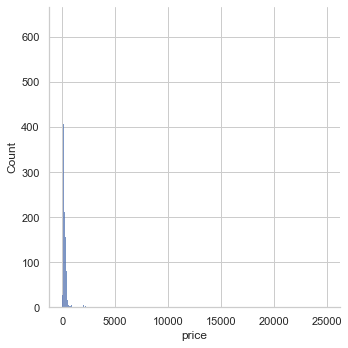

In [18]:
#price distribution 
graph_1 = sns.displot(listings, x="price")
graph_1

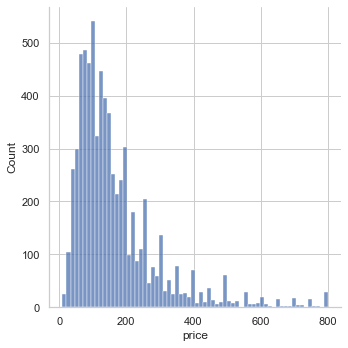

In [19]:
#price distribution without outliers
price_without_outliers= listings[listings['price'] <= 800]
graph_2 = sns.displot(price_without_outliers, x="price")
graph_2

In [20]:
#Stats of number of reviews 
listings.number_of_reviews.describe()

count    7087.000000
mean       43.570340
std        82.587244
min         0.000000
25%         1.000000
50%         7.000000
75%        46.000000
max       821.000000
Name: number_of_reviews, dtype: float64

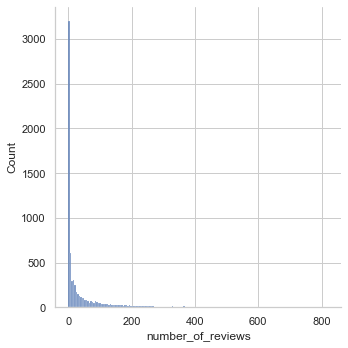

In [21]:
#distribution of number of reviews 
graph_3 = sns.displot(listings, x="number_of_reviews")
graph_3

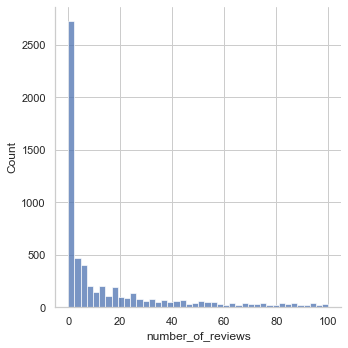

In [22]:
#distribution without outliers
reviews_without_outliers= listings[listings['number_of_reviews'] <= 100]
graph_4 = sns.displot(reviews_without_outliers, x="number_of_reviews")
graph_4

In [23]:
#Counting neighbourhoods 
table_nbds = pd.DataFrame(listings.neighbourhood.value_counts())
table_nbds.rename(columns = {'neighbourhood': 'Count'}, inplace = True)
table_nbds

,Count
"San Francisco, California, United States",5119
"Daly City, California, United States",8
"San Franscisco, California, United States",1
"San Jose, California, United States",1
"San Francisco , California, United States",1
"Noe Valley - San Francisco, California, United States",1
"San Francisco , Ca, United States",1


In [97]:
#Counting neighbourhoods cleansed  
table_nbds2 = pd.DataFrame(listings.neighbourhood_cleansed.value_counts())
table_nbds2.rename(columns = {'neighbourhood_cleansed': 'Count'}, inplace = True)
table_nbds2

,Count
Downtown/Civic Center,697
Mission,649
South of Market,532
Western Addition,486
Haight Ashbury,345
Castro/Upper Market,339
Bernal Heights,314
Noe Valley,296
Nob Hill,291
Outer Sunset,260


In [24]:
#Unique values of neighbourhood_cleansed
listings.neighbourhood_cleansed.unique()

array(['Western Addition', 'Bernal Heights', 'Haight Ashbury', 'Mission',
       'Nob Hill', 'Downtown/Civic Center', 'Castro/Upper Market',
       'Inner Sunset', 'Noe Valley', 'Twin Peaks', 'Potrero Hill',
       'Outer Richmond', 'Glen Park', 'Ocean View', 'Pacific Heights',
       'Financial District', 'South of Market', 'Russian Hill',
       'Outer Sunset', 'Marina', 'Inner Richmond', 'Excelsior',
       'Seacliff', 'Chinatown', 'West of Twin Peaks', 'Bayview',
       'North Beach', 'Presidio', 'Presidio Heights', 'Diamond Heights',
       'Parkside', 'Outer Mission', 'Lakeshore', 'Crocker Amazon',
       'Golden Gate Park', 'Visitacion Valley'], dtype=object)

[Text(0, 0, 'Downtown/Civic Center'),
 Text(1, 0, 'Mission'),
 Text(2, 0, 'South of Market'),
 Text(3, 0, 'Western Addition'),
 Text(4, 0, 'Haight Ashbury'),
 Text(5, 0, 'Castro/Upper Market'),
 Text(6, 0, 'Bernal Heights'),
 Text(7, 0, 'Noe Valley'),
 Text(8, 0, 'Nob Hill'),
 Text(9, 0, 'Outer Sunset'),
 Text(10, 0, 'Russian Hill'),
 Text(11, 0, 'Chinatown'),
 Text(12, 0, 'North Beach'),
 Text(13, 0, 'Potrero Hill'),
 Text(14, 0, 'Inner Richmond'),
 Text(15, 0, 'Bayview'),
 Text(16, 0, 'Marina'),
 Text(17, 0, 'Financial District'),
 Text(18, 0, 'Excelsior'),
 Text(19, 0, 'Outer Richmond'),
 Text(20, 0, 'Inner Sunset'),
 Text(21, 0, 'Pacific Heights'),
 Text(22, 0, 'Outer Mission'),
 Text(23, 0, 'Ocean View'),
 Text(24, 0, 'Parkside'),
 Text(25, 0, 'West of Twin Peaks'),
 Text(26, 0, 'Visitacion Valley'),
 Text(27, 0, 'Glen Park'),
 Text(28, 0, 'Twin Peaks'),
 Text(29, 0, 'Lakeshore'),
 Text(30, 0, 'Crocker Amazon'),
 Text(31, 0, 'Golden Gate Park'),
 Text(32, 0, 'Presidio Heights'),
 

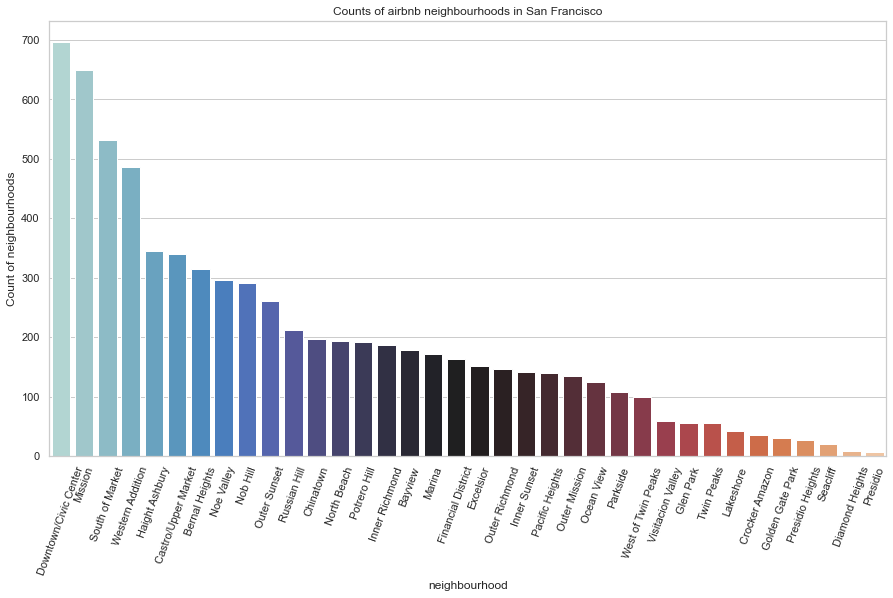

In [25]:
#create a dataframe of neighbourhood cleansed 
table_nbds2=pd.DataFrame(listings.neighbourhood_cleansed.value_counts())
table_nbds2.reset_index(inplace=True)
table_nbds2.rename(columns = {'index':'neighbourhood', 'neighbourhood_cleansed': 'Count'}, inplace = True)

#counting plot of neighbourhoods 
plt.figure(figsize=(15,8))
graph_5=sns.barplot(x='neighbourhood', y='Count', data=table_nbds2, palette = "icefire")
graph_5.set_title('Counts of airbnb neighbourhoods in San Francisco')
graph_5.set_ylabel('Count of neighbourhoods')
graph_5.set_xlabel('neighbourhood')
graph_5.set_xticklabels(graph_5.get_xticklabels(), rotation=70)

Most of the rentals are in Downtown/Civic center, Mission, South of Market, Western Addition, Haight Ashburry, 
Castro/ Upper Market, Bernal Heights, Noe Valley, Nob Hill, Outer Sunset and Russian Hill. 

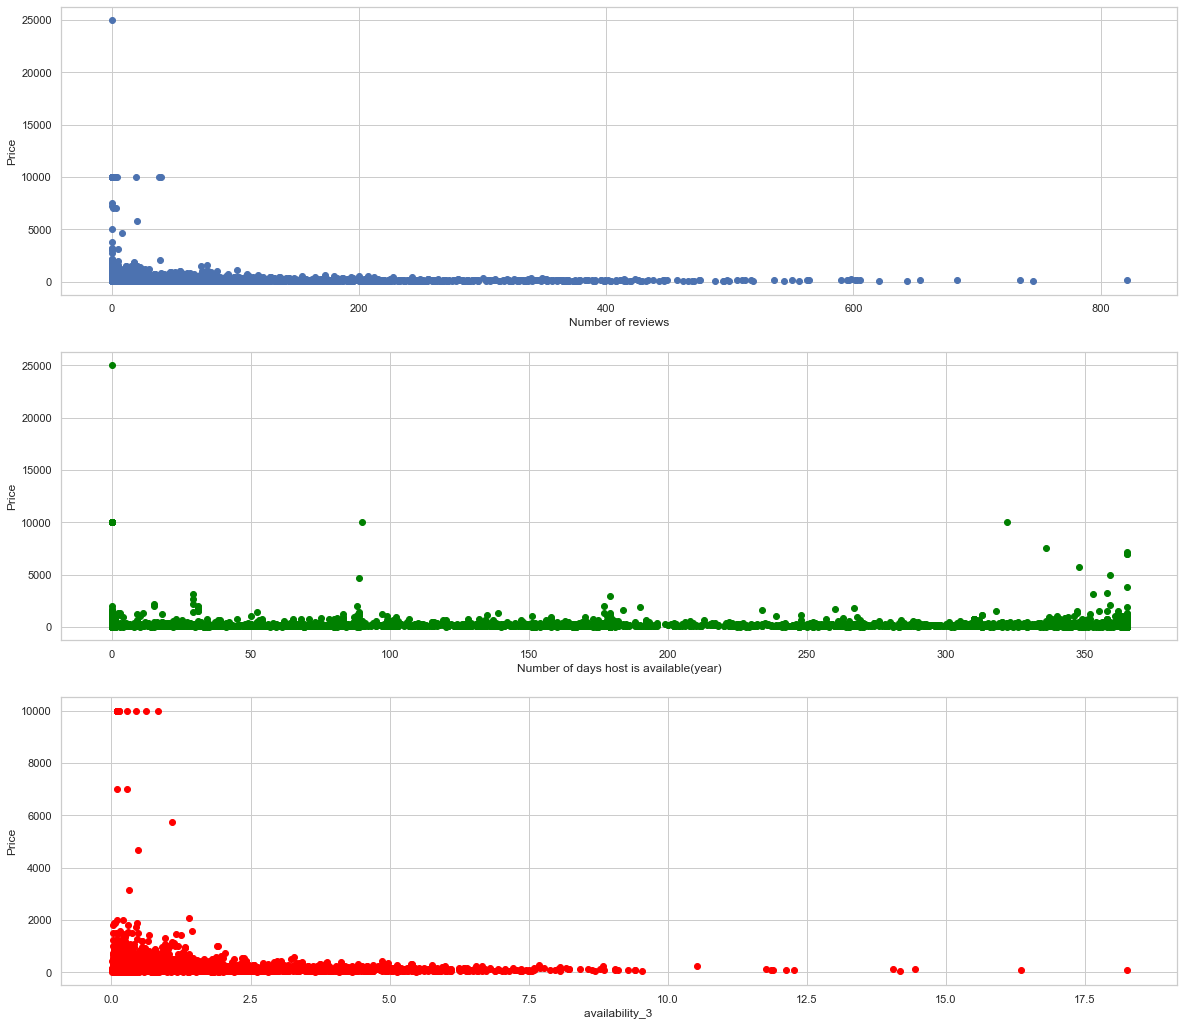

In [28]:
#correlations between prices, number of reviews, reviews per month, and number of days host is available 
fig, axs = plt.subplots(3, figsize=(20,18))

axs[0].scatter(listings.number_of_reviews, listings.price)
axs[0].set(xlabel = 'Number of reviews', ylabel = 'Price')

axs[1].scatter(listings.availability_365, listings.price, c='green')
axs[1].set(xlabel = 'Number of days host is available(year)', ylabel = 'Price')

axs[2].scatter(listings.reviews_per_month, listings.price, c='red')
axs[2].set(xlabel = 'availability_3 ', ylabel = 'Price')


plt.show()

The Price variable correlates with reviews per month and number of reviews. 
The cheap apartments are often the more ranked because of the frecuency of people going
this cheap rentals. On the other part, the_number_of_days_host_is_available has 
no correlation with the price variable. 

In [29]:
#Counting property types
table_propt = pd.DataFrame(listings.property_type.value_counts())
table_propt.rename(columns = {'property_type': 'Count'}, inplace = True)
table_propt

,Count
Entire apartment,2045
Private room in house,966
Entire house,769
Private room in apartment,666
Entire condominium,635
Entire guest suite,454
Room in boutique hotel,335
Private room in condominium,192
Room in hotel,177
Entire serviced apartment,161


The top 3 frecuent type of aprtments is Entire apartment (29%), Private room in house (13%) and Entire house (10%)

In [30]:
#top 10 reviewed prices and their price average 
top_reviewed= listings.nlargest(10,'number_of_reviews')
top_reviewed

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,...,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
264,545685,https://www.airbnb.com/rooms/545685,20201210194755,2020-12-11,"Garden Suite by Golden Gate Park, Private Bathrm","New renovated suite with private sitting room,...",NaN,https://a0.muscache.com/pictures/9d3faf94-d930...,2676602,https://www.airbnb.com/users/show/2676602,Su,2012-06-18,"San Francisco, California, United States",We have been living in San Francisco over than...,NaN,NaN,84%,t,https://a0.muscache.com/im/users/2676602/profi...,https://a0.muscache.com/im/users/2676602/profi...,...,2020-12-11,821,42,0,2012-06-28,2020-03-17,96.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-0000234,f,2,2,0,0,7.97
276,585326,https://www.airbnb.com/rooms/585326,20201210194755,2020-12-11,"Cozy Suite by Golden Gate Park, Private Bathrm","Newly renovated suite with attached, private b...",NaN,https://a0.muscache.com/pictures/c7963ad9-a86b...,2676602,https://www.airbnb.com/users/show/2676602,Su,2012-06-18,"San Francisco, California, United States",We have been living in San Francisco over than...,NaN,NaN,84%,t,https://a0.muscache.com/im/users/2676602/profi...,https://a0.muscache.com/im/users/2676602/profi...,...,2020-12-11,745,30,0,2012-07-14,2020-03-14,96.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-0000234,f,2,2,0,0,7.27
5,8739,https://www.airbnb.com/rooms/8739,20201210194755,2020-12-11,"Mission Sunshine, with Private Bath","Welcome to ""The Mission,"" the sunniest neighbo...",Located between Valencia Street and Dolores Pa...,https://a0.muscache.com/pictures/80811/7a57d0e...,7149,https://www.airbnb.com/users/show/7149,Ivan & Wendy,2009-01-27,"San Francisco, California, United States",Ivan is a publisher of a book for 4 year olds....,within an hour,100%,91%,t,https://a0.muscache.com/im/users/7149/profile_...,https://a0.muscache.com/im/users/7149/profile_...,...,2020-12-11,735,23,0,2009-08-01,2020-03-16,98.0,10.0,10.0,10.0,10.0,10.0,9.0,STR-0000028,f,2,0,2,0,5.31
341,748222,https://www.airbnb.com/rooms/748222,20201210194755,2020-12-11,Sunny Room Heart of the Mission!,We have a 3 bedroom two bath flat with 1 rooms...,"The Mission is a diverse, vibrant neighborhood...",https://a0.muscache.com/pictures/15730517/d452...,516404,https://www.airbnb.com/users/show/516404,Michael And Yesica,2011-04-17,"San Francisco, California, United States",My wife and I lived in San Francisco for 25 ye...,within a day,100%,100%,t,https://a0.muscache.com/im/users/516404/profil...,https://a0.muscache.com/im/users/516404/profil...,...,2020-12-11,684,20,0,2012-11-11,2020-03-15,98.0,10.0,10.0,10.0,10.0,10.0,9.0,STR-0000288,t,1,0,1,0,6.95
319,713877,https://www.airbnb.com/rooms/713877,20201210194755,2020-12-11,Charming Cole Valley Private Suite,"This clean, lovely, self-contained suite will ...",Strolling Cole Valley’s tree-lined streets oft...,https://a0.muscache.com/pictures/miso/Hosting-...,3675617,https://www.airbnb.com/users/show/3675617,Stacey,2012-09-25,"San Francisco, California, United States","Hello! I'm a friendly, open, intellectually c...",within an hour,100%,98%,t,https://a0.muscache.com/im/users/3675617/profi...,https://a0.muscache.com/im/users/3675617/profi...,...,2020-12-11,654,86,7,2012-10-04,2020-12-06,96.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-0002074,f,1,1,0,0,6.56
268,567239,https://www.airbnb.com/rooms/567239,20201210194755,20

In [31]:
#Top 10 reviewed average price 
avrg_prc = top_reviewed.price.mean()
print('Average price per night in San Francisco 2020: {}'.format(avrg_prc))

Average price per night in San Francisco 2020: 124.5


According to the top 10 reviewed rentals with the most reviews 
the average price is 124.5 dls per night. 

[Text(0, 0, '4430421'),
 Text(1, 0, '17042045'),
 Text(2, 0, '48005494'),
 Text(3, 0, '70722023'),
 Text(4, 0, '107434423'),
 Text(5, 0, '117141107'),
 Text(6, 0, '173206762'),
 Text(7, 0, '262211596'),
 Text(8, 0, '267895362'),
 Text(9, 0, '285808053')]

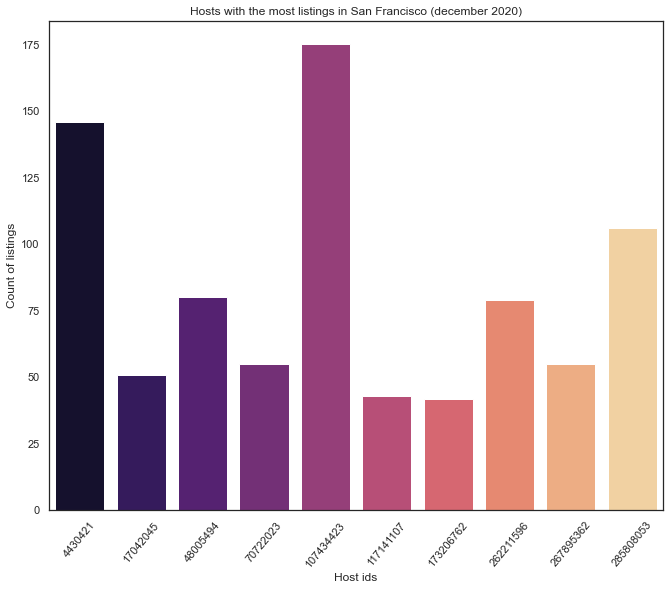

In [32]:
#Counting plot of the top 10 hosts with the most listings on Airbnb platform in San Francisco
super_hosts=listings.host_id.value_counts().head(10)
super_hosts

#create a dataframe of super hosts 
super_host_table=pd.DataFrame(super_hosts)
super_host_table.reset_index(inplace=True)
super_host_table.rename(columns={'index':'host_id', 'host_id':'count'}, inplace=True)

#Graph 
sns.set(rc={'figure.figsize':(11,9)})
sns.set_style('white')
graph_6=sns.barplot(x="host_id", y="count", data=super_host_table,
                 palette='magma')
graph_6.set_title('Hosts with the most listings in San Francisco (december 2020)')
graph_6.set_ylabel('Count of listings')
graph_6.set_xlabel('Host ids')
graph_6.set_xticklabels(graph_6.get_xticklabels(), rotation=50)

There are a few hosts that have more than 75 rentals in San Francisco neighbourhood. 
50% of the them have 1 rental, and 25% have 2 rentals.  

[Text(0, 0, 'in'),
 Text(1, 0, 'private'),
 Text(2, 0, 'room'),
 Text(3, 0, 'with'),
 Text(4, 0, 'the'),
 Text(5, 0, 'bedroom'),
 Text(6, 0, 'studio'),
 Text(7, 0, '-'),
 Text(8, 0, '&'),
 Text(9, 0, 'sf'),
 Text(10, 0, 'home'),
 Text(11, 0, 'mission'),
 Text(12, 0, 'near'),
 Text(13, 0, 'of'),
 Text(14, 0, 'w/'),
 Text(15, 0, 'victorian'),
 Text(16, 0, 'hill'),
 Text(17, 0, 'suite'),
 Text(18, 0, 'san'),
 Text(19, 0, 'and'),
 Text(20, 0, 'apartment'),
 Text(21, 0, 'modern'),
 Text(22, 0, '2'),
 Text(23, 0, 'garden'),
 Text(24, 0, 'to'),
 Text(25, 0, 'sunny'),
 Text(26, 0, 'hotel'),
 Text(27, 0, 'spacious'),
 Text(28, 0, 'park'),
 Text(29, 0, 'union'),
 Text(30, 0, 'francisco'),
 Text(31, 0, '1'),
 Text(32, 0, 'square'),
 Text(33, 0, 'valley'),
 Text(34, 0, 'cozy'),
 Text(35, 0, 'house'),
 Text(36, 0, 'by'),
 Text(37, 0, 'bath'),
 Text(38, 0, 'a'),
 Text(39, 0, 'view'),
 Text(40, 0, 'views'),
 Text(41, 0, 'flat'),
 Text(42, 0, 'heart'),
 Text(43, 0, 'condo'),
 Text(44, 0, 'beautiful'),

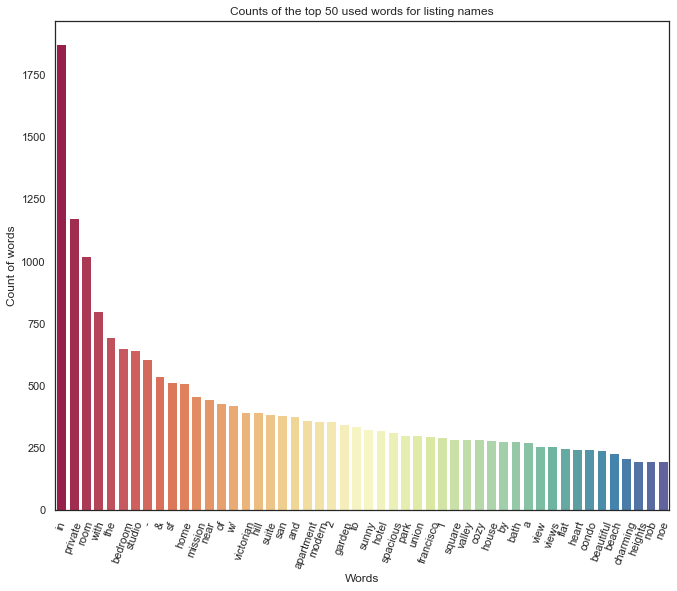

In [33]:
#analizing the words in the name variable 

names_listings=[]
for name in listings.name:
    names_listings.append(name) 
    
def splitting(name):
    splt=str(name).split()
    return splt 

names_count=[]

for i in names_listings:
    for j in splitting(i):
        words = j.lower()
        names_count.append(words)
        
#See the 50 most frequent words 
top_50_words=Counter(names_count).most_common()
top_50_words=top_50_words[0:50]

words_table=pd.DataFrame(top_50_words)
words_table.rename(columns={0:'words', 1:'count'}, inplace=True)

#plot 
graph_7=sns.barplot(x='words', y='count', data=words_table, palette = "Spectral")
graph_7.set_title('Counts of the top 50 used words for listing names')
graph_7.set_ylabel('Count of words')
graph_7.set_xlabel('Words')
graph_7.set_xticklabels(graph_7.get_xticklabels(), rotation=70)

In [91]:
print(list(listings.name.values))

['Bright, Modern Garden Unit - 1BR/1BTH', 'Creative Sanctuary', 'A Friendly Room - UCSF/USF - San Francisco', 'Friendly Room Apt. Style -UCSF/USF - San Francisco', 'Historic Alamo Square Victorian', 'Mission Sunshine, with Private Bath', 'Victorian Suite in Inner Mission', 'Classic Nob Hill Studio - Roof Deck', 'Haight Buena Vista Park Garden 3BR', 'Victorian House in Hayes Valley - 3BED-2BA', 'Union Square Modern Loft', 'Sunny/Sunset view room UCSF/USF - San Francisco', 'Sunny/Sunset view room UCSF/USF - San Francisco', 'Perfectly located Castro', 'Views, sun, 12 ft ceilings, decks, 2BR work/sleep', 'Loft-like Apt./Garden (monthly only available)', 'Lower Haight Urban Zen with private bath', 'Studio loft on top of Russian Hill', 'Castro Guest Suite With Continental Breakfast', 'Potrero Hill "Nest" Quiet, Comfy & Convenient', "San Francisco's Luxury Oasis Private Room On Noe", 'Modern Zen in the Lower Haight', 'Convenient, quiet, private', 'Huge Central Victorian/Alamo Square', 'Modern

Removing prepositions and other non-letters, most of the hosts in San Francisco offer or promote private rooms,
studio rooms, number of bedrooms, sunny places, room apartments, modern apartment, gardens, views, spacious, 
flat types, rooms in hotel views , baths, condos, and charming rooms. 

# Prepare Data 

Once we analyze the listings dataset, it's importante to clean all the variables in order to model.  We're interested in the price variable and the variables related to it: factors that affect the price rentals, amenities that contributes most of the earnings to the rentals. We cannot use ids and dates variables for theses analysis.

## Cleanning and feature engineering 

In [34]:
#drop unnecesary variables like id and host name 
listings.drop(['id','host_name'], axis=1, inplace=True)

In [35]:
#creating new variable "revenue per availble room"
listings["rev_per_avail_room"] = (listings['price'] * (30 - listings['availability_30']))

In [36]:
#create a new binary target variable for the classification model
Average_revPerAvailr = listings["rev_per_avail_room"].mean()
listings["winner"] = [1 if x >= Average_revPerAvailr else 0 for x in listings["rev_per_avail_room"]]

The revenue per available room is a performance metric used in the hotel 
industry. It is calculated by multiplying a hotel's average daily room rate by its
occupancy rate. We'll use it to group hosts that rent with a highest price than the average monthly revenue (winners as 1), and the others that earn less than the revenue per availability room (no winner as 0). 

In [37]:
#Tranform in a binary feature the amenity variables to analyze the importance of the 
#contribution in the rental earnings of San Francisco

amenities_list = ['Kitchen', 'Shampoo', 'Dryer Essentials', 'Private entrance', 'Garden or backyard', 
                  'Stove', 'Cable TV', 'Coffee maker','Washer', 'Hair dryer', 'Iron', 'Wifi', 
        'Dishes and silverware', 'Room darkening shades', 'Keypad', 'Microwave Oven', 'Heating', 'Refrigerator', 'Essentials',
       'Play travel crib', 'Cooking basics', 'Hangers', 'Free street parking',
       'Smoke alarm', 'First aid kit', 'Hot water', 'Dedicated workspace',
       'Fire extinguisher', 'Host bedroom door', 'Dishwasher', 'Bed linens', 'Extra pillows and blankets', 
       'Luggage drop off allowed', 'Indoor fireplace', 'Children books and toys',
       'Lockbox', 'High chair', 'Elevator', 'Patio or balcony', 'Free parking on premises'
       'Paid parking off premises', 'Babysitter recommendations', 'Baby safety gates',
       'BBQ grill', 'Long term stays',
       'Ethernet connection', 'Hot tub', 'Pocket wifi', 'Breakfast',
       'Body soap', 'Air conditioning', 'Full kitchen', 
       'Bedroom comforts', 'Bathroom essentials', 'Shower gel',
       'Private living room', 'Children dinnerware', 'Bathtub', 'Ceiling fan',
       'Mini fridge', 'In building', 'Portable fans', 'HDTV', 'Netflix', 'Amazon', 'Prime Video',
        'HBO Max', 'Chromecast', 'Single level home',
       'Pool', 'Building staff', 'Gym', 'Cleaning before checkout', 
       'Baking sheet','Conditioner unit', 'Stainless steel gas stove', 
       'Stainless steel oven',
       'Freezer', 'Game console','Sound system', 'Fireplace guards', 'Electric stove', 'Outlet',
       'covers', 'EV', 'charger', 'Bread', 'Rice', 'Changing table',
       'Barbecue utensils', 'Window guards', 'Kitchenette', 'Smart lock',
       'Table corner', 'Kitchen standard cable', 'HDTV with standard', 'Record player',
       'Sonos', 'Bluetooth sound', 'Pour over coffee' , 'Baby monitor',
       'Pantene conditioner', 'Nespresso machine',
       'Panasonic sound system with aux Patio',
       'Sound system with Bluetooth and aux', 'Trash compactor', 
       'Piano', 'Pets allowed', 'Self check', 'Laundromat nearby', 'Beach essentials', 
       '100 Mbps', '20 Mbps','600 Mbps','1000 Mbps','90 Mbps','500 Mbps','700 Mbps',
       '240 Mbps', 'double burner', 'Black Decker',
       'electric stove', 'Beachfront', 'Waterfront', 'Central heating', 
        'Free driveway parking ', 'Free residential garage', 'Paid parking garage', '1 space',
        'Cafe', 'stainless steel oven ', '2 spaces',
        'Suitable events', 'Cook top induction', 'Verona stainless steel oven', 'Undercounter half size fridge',
        'Dishwasher Dr Bronner','Bose sound system',
        'Samsung refrigerator', 'Portable heater', 'Kitchen premium cable', 
        'HDTV with premium', 'Taotronics sound system', 'EO Organics', 'EO body soap', 'EO conditioner'
        'Smoking allowed', 'Denon', 'Bosch', 'Jenn', 'Yamaha', 
        'Self check in', 'Shared fenced garden or backyard', 'Shared hot tub',
        'Lake access', 'Hot water kettle', 'Clothing storage',
        'Dining', 'Outdoor dining area', 'Cleaning products', 'Suave body soap',           
        'Bed linens Bergman ', 'Techwood', 'Countertop', 'Double Burner', 'Infrared', 'Ceramic', 'Cooktop',
        'Double Cooktop 1800W With Adjustable Temperature Control', 'Brushed', 'Easy to Clean',
        'Upgraded Version', 'Neutrogena body soap ', 
        'Frigidare gas stove', 'bose sound system', 'Toaster', 'Convection', 'Apple', 
        'Roku','Alba conditioner', 'Alba shampoo', 'Cuisinart', 
        'Sonos 3 speakers', 'Niles speakers', 'Paradigm speakers sound system with aux', 
        'Polk built in speakers with Airplay sound system',  'Sonos JBL in ceiling speakers', 
        'Harmon Kardon', 'Shea Logix', 'Clothing storage closet', 'Terrace', 'Walk in closet', 'Wine glasses',
        'Wine cooler', 'Whirlpool electric', 'Whirlpool oven', 'Technics receiver amp',
        'Summer s Eve', 'Cleansing', 'Costco', 'bar', 'Fire pit',
        'Outdoor furniture ', 'Vintage', 'Magic Chef',
        'medium size refrigerator', 'Thermidor refrigerator', 'Thermidor gas stove', 
        'Dual vanity', 'Stand alone rain', 'Stand alone steam shower', 'Media room', 
        'Espresso machine', 'Nest thermometer', 'Ironing board', 'Home theater',
        'Wet bar', 'Security cameras', 'AC valet',
        'freezer', 'Dove sensitive skin body soap', 'Radiant heating', 'Induction',
        'Dacor refrigeratos', 'Aesop body soap', 'Aesop conditioner', 'Aesop shampoo', 'Aveno body',
        'Lounge', 'Gas', 'Desk', 'Natural gas', 'barbeque',
        'Harmon Kardon NXT and Yamaha in wall theater system sound system', 'wall', 
        'Sony sound system', 'Boze','Indoor fireplace'
        'Courtyard', 'Massage table','Carbon monoxide alarm', 
        'Driveway parking', 'Wood burning fireplace ', 'Jetted tub',
        'Smart home technology', 'In top shelf in closet', 'organic body soap', 'Greenwich Bay',
        'Exfoliating Body', 'Tea body soap Enriched with Shea Butter',
        'Moist conditioner Blended with Loofah and Apricot Seed', 
        'Lemongrass', ' Aussie Deep Conditioner',
        'Love Beauty and Planet eco conscious brand', 
        'Parasound', 'audiophile equipment sound system with Bluetooth and aux'
        'HomePods', 'Maytag refrigerator', 'Heating skillet stove', 'Ace Hotel',
        'Fisher Paykel', 'Bertazoni stainless steel oven', 'JBL',
        'Electrolux refrigerator', 'Thermador stainless steel gas stove', 
        'Google', 'Marshall Bluetooth sound system', 'Luggage dropoff allowed', 'Keefe and Merritt']
for amenity in amenities_list:
    listings[amenity] = listings.amenities.str.contains(amenity)

In [38]:
#Create a new base with amennities, reviews and rooms' characteristics variables for modeling
#filter by index columns 
features_ = listings.iloc[: ,[15, 25,29,30,31,34,58,71]].join(listings.iloc[:,73:339])

In [39]:
#we apply dummy fucntion to this object variables
features_ = pd.get_dummies(features_, columns=['host_is_superhost', 'neighbourhood_cleansed','property_type', 'room_type'])

In [40]:
#table of null values 
pd.set_option('display.max_rows', 370)
table_ofnulls = pd.DataFrame(features_.isnull().sum())
table_ofnulls.rename(columns= {0:'Counts'}, inplace = True)
table_ofnulls

,Counts
accommodates,0
bedrooms,882
review_scores_rating,1745
reviews_per_month,1703
winner,0
Kitchen,0
Shampoo,0
Dryer Essentials,0
Private entrance,0
Garden or backyard,0


In [41]:
#Applying ordinal econder for categorical variables  
enc = OrdinalEncoder()
enc.fit(features_.iloc[:,5:270])
features_.iloc[:,5:270] = enc.transform(features_.iloc[:,5:270])

## Models

We build 2 models to predict earnings based on amenities, factors or characteristics of the rentals, and model the 
rental prices. The primary purpose is to analyze the models results and identify which are the most important 
variables in order to obtain higher earnigns and modeling the prices based on these variables.
We only use a subset of the original variables. Variables with few missing values are used. For simplicity we omit 
ids and date variables.

We implement xgboost models.

### Classification model 

In [42]:
#Split into Train and Test
X= features_.drop("winner",axis=1)
y= features_[['winner']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#fit 
xgbm = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
grow_policy='depthwise', n_estimators= 50, random_state= 42)
xgbm.fit(X_train, y_train)
#pred, confusion matrix, class report 
predictions_xgb =xgbm.predict(X_test)
xgb_probs = xgbm.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_xgb))

print("Classification Report")
print(classification_report(y_test, predictions_xgb))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix:
[[1022   64]
 [ 157  175]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1086
           1       0.73      0.53      0.61       332

    accuracy                           0.84      1418
   macro avg       0.80      0.73      0.76      1418
weighted avg       0.84      0.84      0.83      1418



In [43]:
#Scores
TP= 175
FP= 64
FN= 157
TN= 1022
accuracy_s = (TP + TN)/ (TP + FN + TN + FP)
recall_score =  TP / (FN + TP)
precision_score= TP / (FP + TP)
f1_score = 2* precision_score * recall_score/ (precision_score + recall_score)
print('Accuracy score: ', accuracy_s)
print('Recall score: ', recall_score)
print('Precision score: ', precision_score)
print('f1_score: ', f1_score)

Accuracy score:  0.8441466854724965
Recall score:  0.5271084337349398
Precision score:  0.7322175732217573
f1_score:  0.6129597197898423


Train/Test results :
XGBClassifier accuracy : 0.844
XGBClassifier log_loss : 0.365
XGBClassifier auc : 0.875


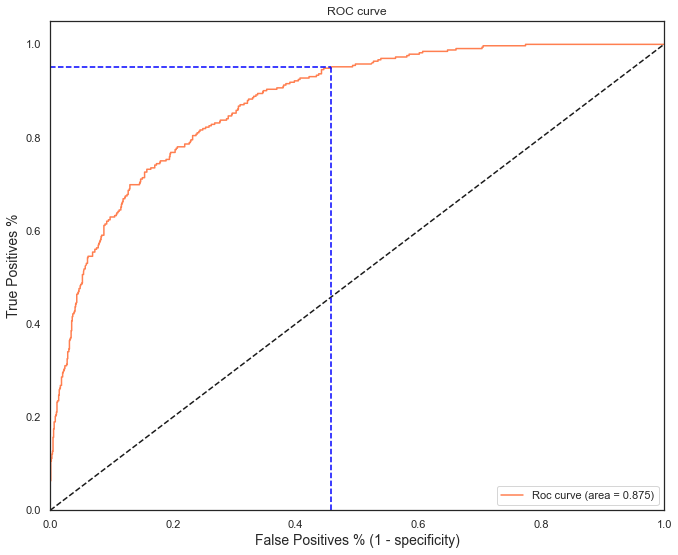

In [44]:
#Roc curve
[fpr_xgb, tpr_xgb, thr_xgb] = roc_curve(y_test, xgb_probs)
print('Train/Test results :')
print(xgbm.__class__.__name__+" accuracy : %2.3f" % accuracy_score(y_test, predictions_xgb))
print(xgbm.__class__.__name__+" log_loss : %2.3f" % log_loss(y_test,xgb_probs))
print(xgbm.__class__.__name__+" auc : %2.3f" % auc(fpr_xgb, tpr_xgb))

idx_xgb = np.min(np.where(tpr_xgb > 0.95))

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='coral', label='Roc curve (area = %0.3f)' % auc(fpr_xgb, tpr_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr_xgb[idx_xgb]], [tpr_xgb[idx_xgb],tpr_xgb[idx_xgb]], 'k--', color='blue')
plt.plot([fpr_xgb[idx_xgb],fpr_xgb[idx_xgb]], [0,tpr_xgb[idx_xgb]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives % (1 - specificity)', fontsize=14)
plt.ylabel('True Positives %', fontsize=14)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
#GINI
roc_auc =0.875
GINI = (2 * roc_auc) - 1
print("Gini:", GINI,"\n")

#kappa 
print("Kappa:", cohen_kappa_score(y_test,predictions_xgb), "\n")

Gini: 0.75 

Kappa: 0.5186072733193852 



### Prediction model

In [46]:
#create a factors dataset for modeling prices 
#filter index columns
factors =listings.iloc[: , [15,30,34,37,38,39,40,41,42,44,48,49,50,51,53,58,71]].join(listings.iloc[:,74:338])

In [47]:
#applying ordinal encoder for categorical values 
enc = OrdinalEncoder()
enc.fit(factors.iloc[:,17:282])
factors.iloc[:,17:282] = enc.transform(factors.iloc[:,17:282])

#we apply dummy fucntion to this object variable: room type and host is superhost
factors = pd.get_dummies(factors, columns=['room_type','host_is_superhost'])

In [48]:
#Applying a XGBoost Algorithm for prediction

#Splitting the dataset 
X= factors.drop("price",axis=1)
y= factors[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train= X_train.loc[:,~X_train.columns.duplicated()]
X_test= X_test.loc[:,~X_test.columns.duplicated()]

#Fit 
xgb2 = XGBClassifier(objective = 'reg:squarederror')
xgb2.fit(X_train,y_train)

#predictions
pred_train= xgb2.predict(X_train)
print('\nTarget on Train',pred_train)

pred_test= xgb2.predict(X_test)

print('\nTarget on Test',pred_test)

#R2 and RMSE scores 
print('Train r2 score : ', r2_score(pred_train, y_train))
print('Test r2 score : ', r2_score(y_test, pred_test ))

train_mse1 = mean_squared_error(pred_train, y_train)
test_mse1 = mean_squared_error(pred_test, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)

print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[15:46:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Target on Train [ 90 179 131 ... 140 232 250]

Target on Test [150 150  60 ... 125 174 145]
Train r2 score :  0.6920078301712489
Test r2 score :  0.5156882864948525
Train RMSE: 460.3895
Test RMSE: 515.5589


## Evaluation 

### Question 1

We implement xgboost because it's 
a powerful algorithm due to its regularization to overcome overfitting, eficient handling missing data, tree pruning using depth-first approach among others.

The confusion matrix show us: 

True Negative (TN) represents the value of correct predictions of negatives out of actual 
negative cases. Out of 1086 actual negative, 1022 is correctly predicted negative. Thus,
the value of True Negative is 1022.

False Positive (FP): False positive represents the value of incorrect positive predictions
This value represents the number of negatives (out of 1086) which gets falsely predicted as
positive. Out of 1086 actual negative, 64 is falsely predicted as positive. Thus, the value 
of False Positive is 64.

False Negative (FN): False negative represents the value of incorrect negative predictions.
This value represents the number of positives (out of 334) which gets falsely predicted as
negative. Out  334 of actual positive, 159 is falsely predicted as negative. Thus, 
the value of False Negative is 159.

True Positive (TP) represents the value of correct predictions of positives out of actual positive cases. 
Out of 334 actual positive, 175 are correctly predicted positive. Thus, the value of
True Positive is 175.

We got an accuracy of 84%, which is a measure of model performance in terms of measuring 
the ratio of sum of true positive and true negatives out of all the predictions made.

For the recalll we got an score of 52%, that is used to measure the model performance 
in terms of measuring the count of true positives in correct manner out of all the actual
positive values.

For the preciscion score we got an 73%, that is used to measure the model performance 
on measuring the count of true positives in correct manner out of all positive predictions
made.

And the final score, the F1 score, we got an 61% that is the harmonic mean of precision 
and recall score and is used as a metrics in the scenarios where choosing either of 
precision or recall score can result in compromise in terms of model giving high false 
positives and false negatives respectively.

The ROC is a probability curve and AUC represents degree or measure of separability.
It tells how much model is capable of distinguishing between classes. Higher the AUC, 
better the model is at predicting 0s as 0s and 1s as 1s. With a higher AUC (0.875), 
better the model is at distinguishing between hosts with high revenue and hosts with 
lower revenue. 

The Gini coefficient measures the inequality among values of a frequency distribution 
A Gini coefficient of zero expresses perfect equality, where all values are the same 
A Gini coefficient of one (or 100%) expresses maximal inequality among values. 
We got an 75%, wich means that our values express inequality at some point. 

The Kappa statistics assess the inter-rater reliability or agreement of values. 
In this case, we got 51.8% of agreements, while the other 48.2% represent faulty data.

### Visualization 

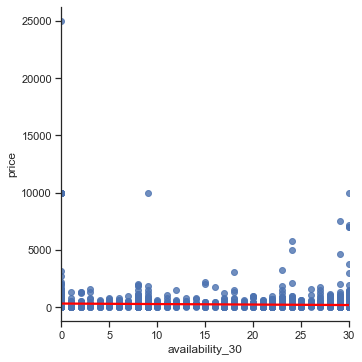

In [49]:
#realtionship between price and occupacy rate 
sns.set(style="ticks")
sns.lmplot(x="availability_30", y="price", data=listings, line_kws={'color': 'red'})
plt.show()

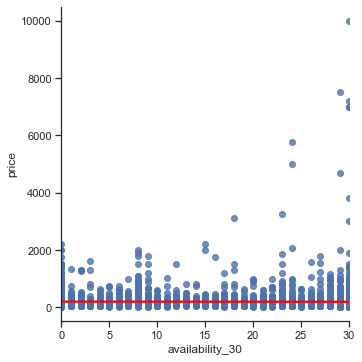

In [50]:
#realtionship between price and occupacy rate (whitout outliers)
reven_PAvailRroom_without_outliers = listings[np.abs(listings.rev_per_avail_room-listings.rev_per_avail_room.mean())<=(3*listings.rev_per_avail_room.std())]
sns.lmplot(x="availability_30", y="price", data=reven_PAvailRroom_without_outliers, line_kws={'color': 'red'})
plt.show()

There is not correlation between price and availability (30 days) 
The proportion of cheap and occupied rooms seems to be the same to the cheap rooms 
that are not always occupied.

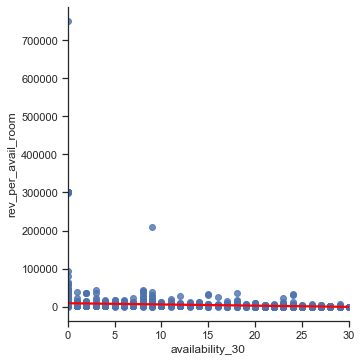

In [51]:
#relationship between revenue per available room and availability 
sns.lmplot(x="availability_30", y="rev_per_avail_room", data=listings, line_kws={'color': 'red'})
plt.show()

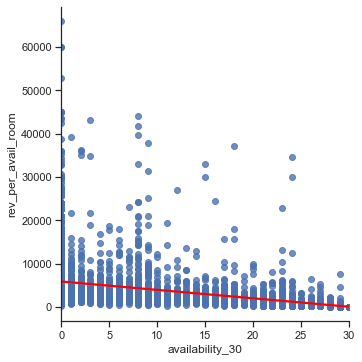

In [52]:
#relationship between revenue per available room and availability  (whitout outliers)
sns.lmplot(x="availability_30", y="rev_per_avail_room", data= reven_PAvailRroom_without_outliers,  line_kws={'color': 'red'})
plt.show()

In this plot we observe that variable revenue per availability decreases as vailability increases. 
There is no correlation. 

In [88]:
#The average and the median monthly revenue
print("Average Monthly Revenue:", listings["rev_per_avail_room"].mean())
print("Median Monthly Revenue:", listings["rev_per_avail_room"].median())

Average Monthly Revenue: 4870.320586990264
Median Monthly Revenue: 2016.0


The average monthly revenue is 4870 dls and the median is 2016 dls. 
In other words, the first half earn of this population at least 2016 dls by month,
in the other hand the other half earn by far 4870 dls by month.

In [53]:
# 
amenities_list.append('winner')
for contribution in amenities_list:
    print(listings.groupby(contribution)['winner'].mean())

Kitchen
False    0.269055
True     0.209654
Name: winner, dtype: float64
Shampoo
False    0.156980
True     0.242709
Name: winner, dtype: float64
Dryer Essentials
False    0.22252
Name: winner, dtype: float64
Private entrance
False    0.181216
True     0.278498
Name: winner, dtype: float64
Garden or backyard
False    0.205659
True     0.271280
Name: winner, dtype: float64
Stove
False    0.219684
True     0.226761
Name: winner, dtype: float64
Cable TV
False    0.181629
True     0.308399
Name: winner, dtype: float64
Coffee maker
False    0.189056
True     0.247831
Name: winner, dtype: float64
Washer
False    0.192308
True     0.234415
Name: winner, dtype: float64
Hair dryer
False    0.120428
True     0.241703
Name: winner, dtype: float64
Iron
False    0.119301
True     0.246058
Name: winner, dtype: float64
Wifi
False    0.044872
True     0.226519
Name: winner, dtype: float64
Dishes and silverware
False    0.22370
True     0.22153
Name: winner, dtype: float64
Room darkening shades
False  

We can observe how by each amenity it contributes to the success of rooms rentals, by
grouping by amenity type and the mean of the rooms with high revenue.

In [54]:
#correlations with the variable winner 
table_corr = pd.DataFrame(features_[features_.columns[:]].corr()['winner'])
table_corr.rename(columns= {'winner': 'Correlation'}, inplace = True)
table_corr.sort_values(by=['Correlation'], ascending= False)

,Correlation
winner,1.000000
accommodates,0.349343
bedrooms,0.344171
property_type_Entire house,0.214745
room_type_Entire home/apt,0.211923
Gym,0.199928
Air conditioning,0.189308
Bathtub,0.167434
Building staff,0.166638
property_type_Room in hotel,0.151336


The variables with high correlations are: accomodates, bedrooms, review_scores_rating, 
entire hourse, entire apartement, gym, air conditioning, bathtub, building staff, room in hotel. 

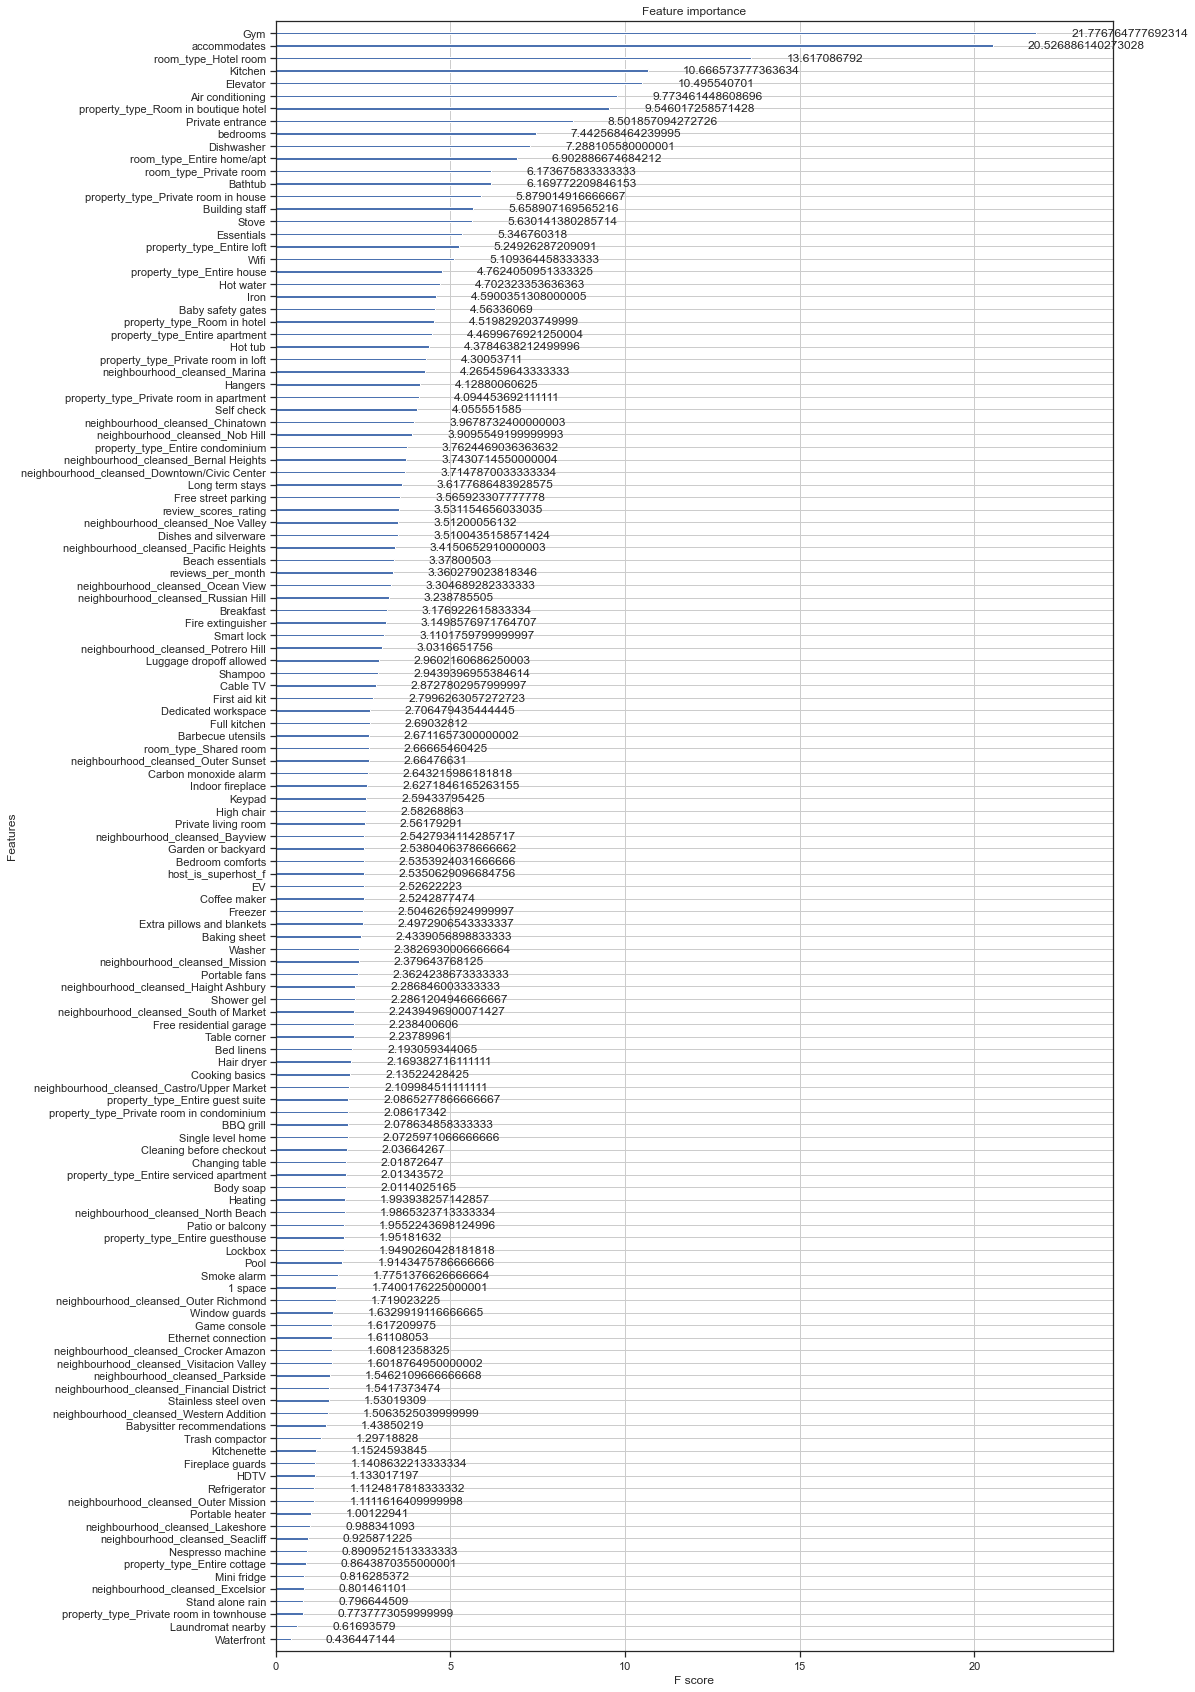

In [55]:
#feature importance 
fig, ax = plt.subplots(figsize=(15,30))
plot_importance(xgbm, ax = ax, importance_type="gain")
#plt.rc('ytick',labelsize=0)
plt.show()

According to the Feature importance type "Gain", which implies the relative contribution
of the corresponding feature to the model calculated by taking each feature's 
contribution for each tree in the model, the top 10 that describe our moder are:
gym, accomodates, hotel room, kitchen, elevator, air conditioning, boutique hotel room , private entrance, bedrooms, and dishwasher. 

The most important amenities: gym, kitchen, elevator, air conditioning, dishwasher, bathtub, building staff. 
The most important characteristics of a rental: accomodates, number ob bedrooms, private entrance. The most important room types:  hotel rooms,  entire home apartment, private room. And the most important properties types: boutique hotel rooms, private room, entire loft, entire house.

## Question 2

### Here we explore and examine the effects on price variable.

### Visualize 

In [56]:
listings.price.describe()

count     7087.000000
mean       248.599125
std        817.421870
min         10.000000
25%         85.000000
50%        133.000000
75%        215.000000
max      25000.000000
Name: price, dtype: float64

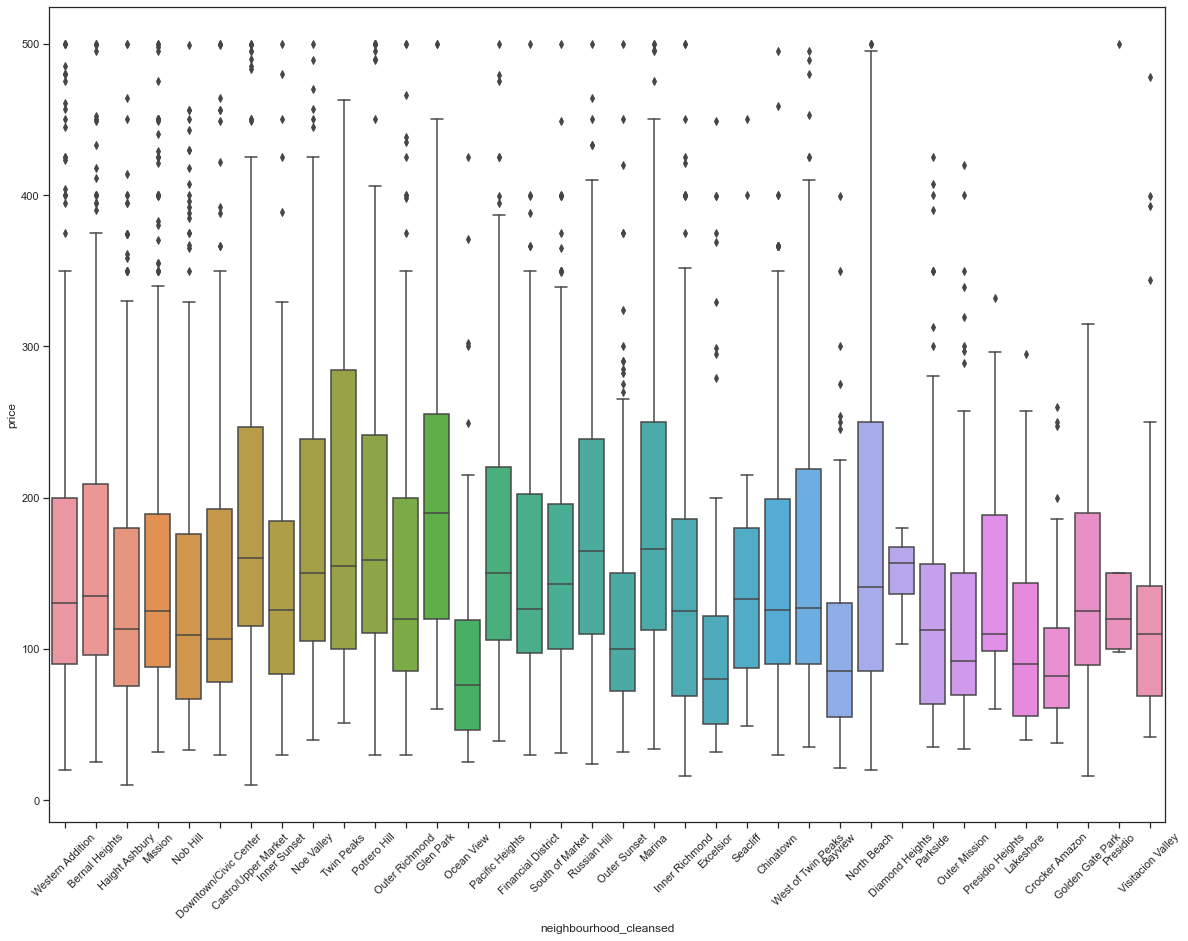

In [57]:
#box plot of neoghbourhoods
neighb_prices = listings[listings['price'] <= 500]
plt.figure(figsize=(20,15))
sns.boxplot(x='neighbourhood_cleansed',y='price',data= neighb_prices)
plt.xticks(rotation=45)
plt.show()

The neighbourhood with the highest median price is Glen Park. The neighbourhood with no outliers are: 
Presidio and Diamond Heights. The neighbourhood with the cheapest rooms are in Ocean View. The is a 
high variability in the prices of rental rooms among the neighbourhoods.

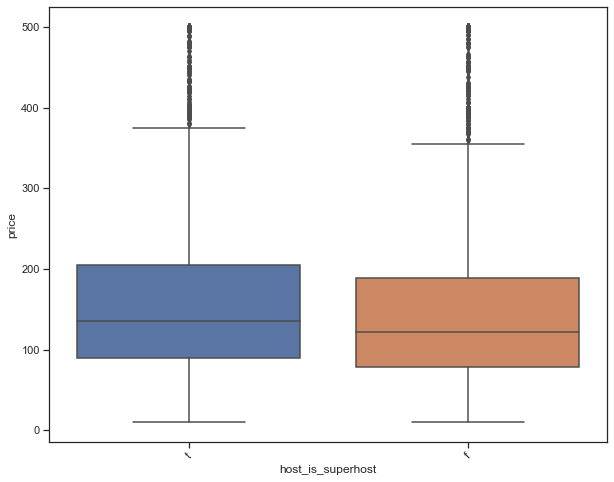

In [58]:
#boxplot of super host variable 
plt.figure(figsize=(10,8))
sns.boxplot(x='host_is_superhost',y='price',data= neighb_prices )
#graph_3=plt.gca()
#graph_3.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.xticks(rotation=45)
plt.show()

It seems that any statistical difference between superhost prices and not superhost
prices.

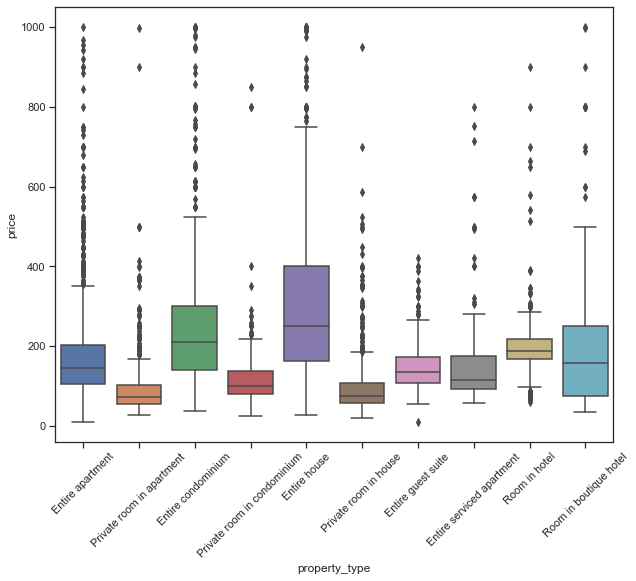

In [59]:
#Box plot of price and the top 10 property types
properties_ = ['Entire apartment', 'Private room in house', 'Entire house',
       'Private room in apartment', 'Entire condominium',
       'Entire guest suite', 'Room in boutique hotel',
       'Private room in condominium', 'Room in hotel',
       'Entire serviced apartment']
properties_ = listings.property_type.isin(properties_ )
properties_ =listings[properties_]
properties_ = properties_.reset_index(drop=True)
properties_ = properties_[properties_['price'] <= 1000]
plt.figure(figsize=(10,8))
sns.boxplot(x='property_type',y='price',data= properties_)

plt.xticks(rotation=45)
plt.show()

The property type has a high correlation of the price. For this case the median price 
for this categories are between 100 and 300 dollars. 

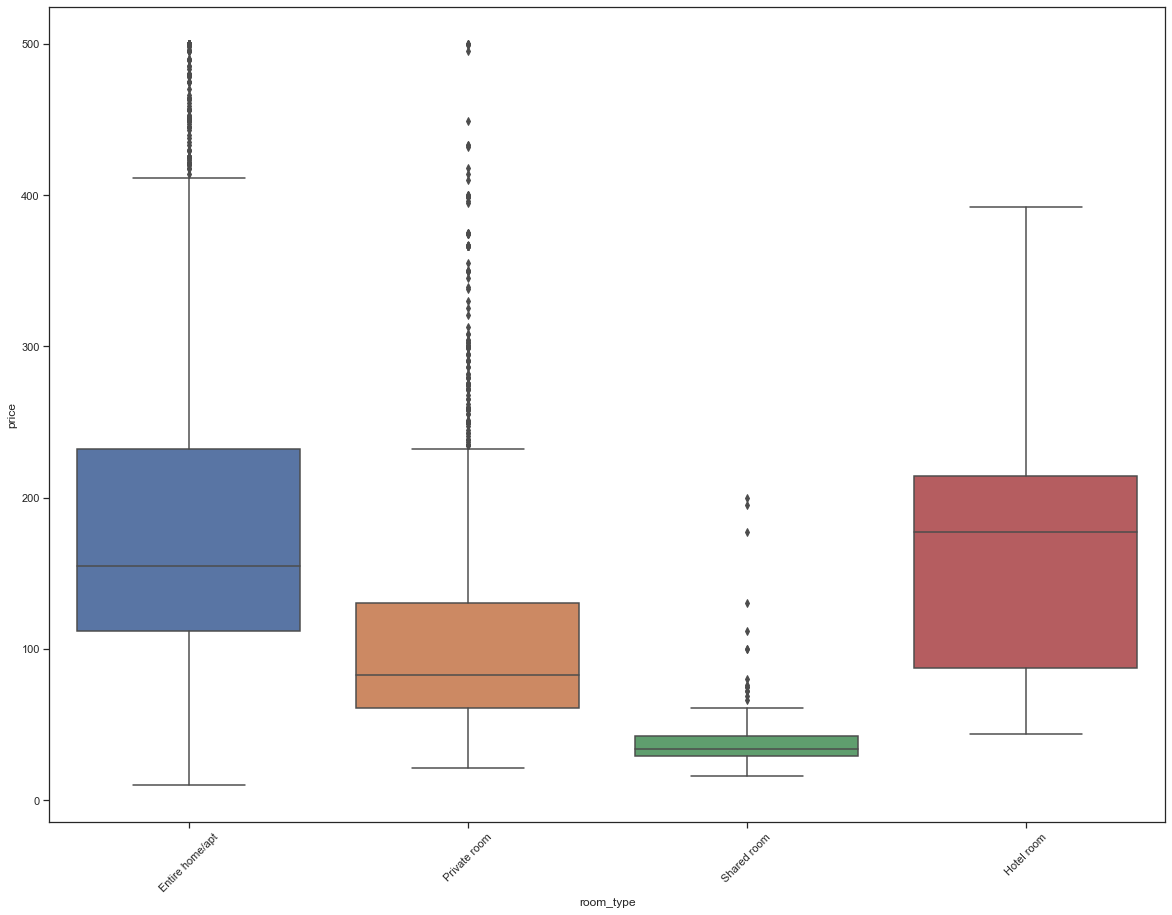

In [60]:
#Box plot of room type 
plt.figure(figsize=(20,15))
sns.boxplot(x='room_type',y='price',data= neighb_prices)
plt.xticks(rotation=45)
plt.show()

Shared rooms tend to be cheapest than other type rooms. Enrite home/apt almost has the same price as hotel rooms
Private rooms tend to have outliers in their prices.

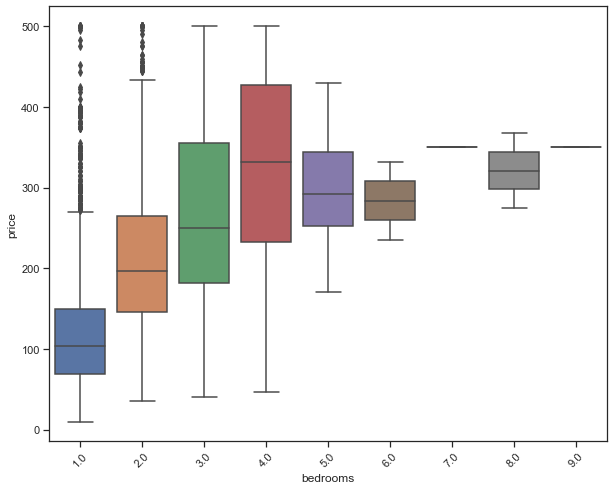

In [61]:
#box plot of bedrooms 
plt.figure(figsize=(10,8))
sns.boxplot(x='bedrooms',y='price',data= neighb_prices)
plt.xticks(rotation=45)
plt.show()

Seems that if the number of bedrooms increase, price rental also increases until the fifth bedroom.

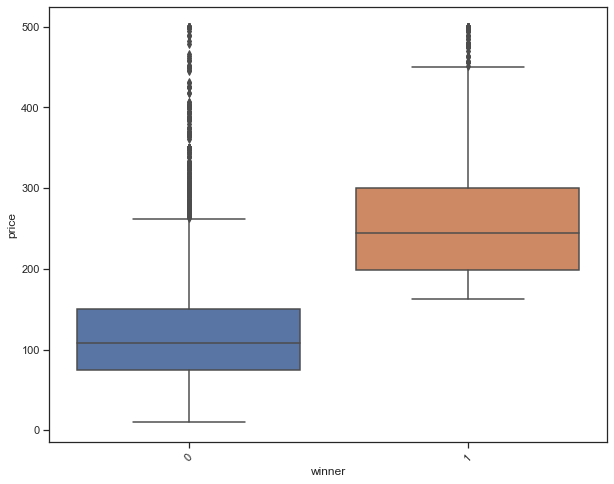

In [62]:
#boxplot of winner 
plt.figure(figsize=(10,8))
sns.boxplot(x='winner',y='price',data= neighb_prices)
plt.xticks(rotation=45)
plt.show()

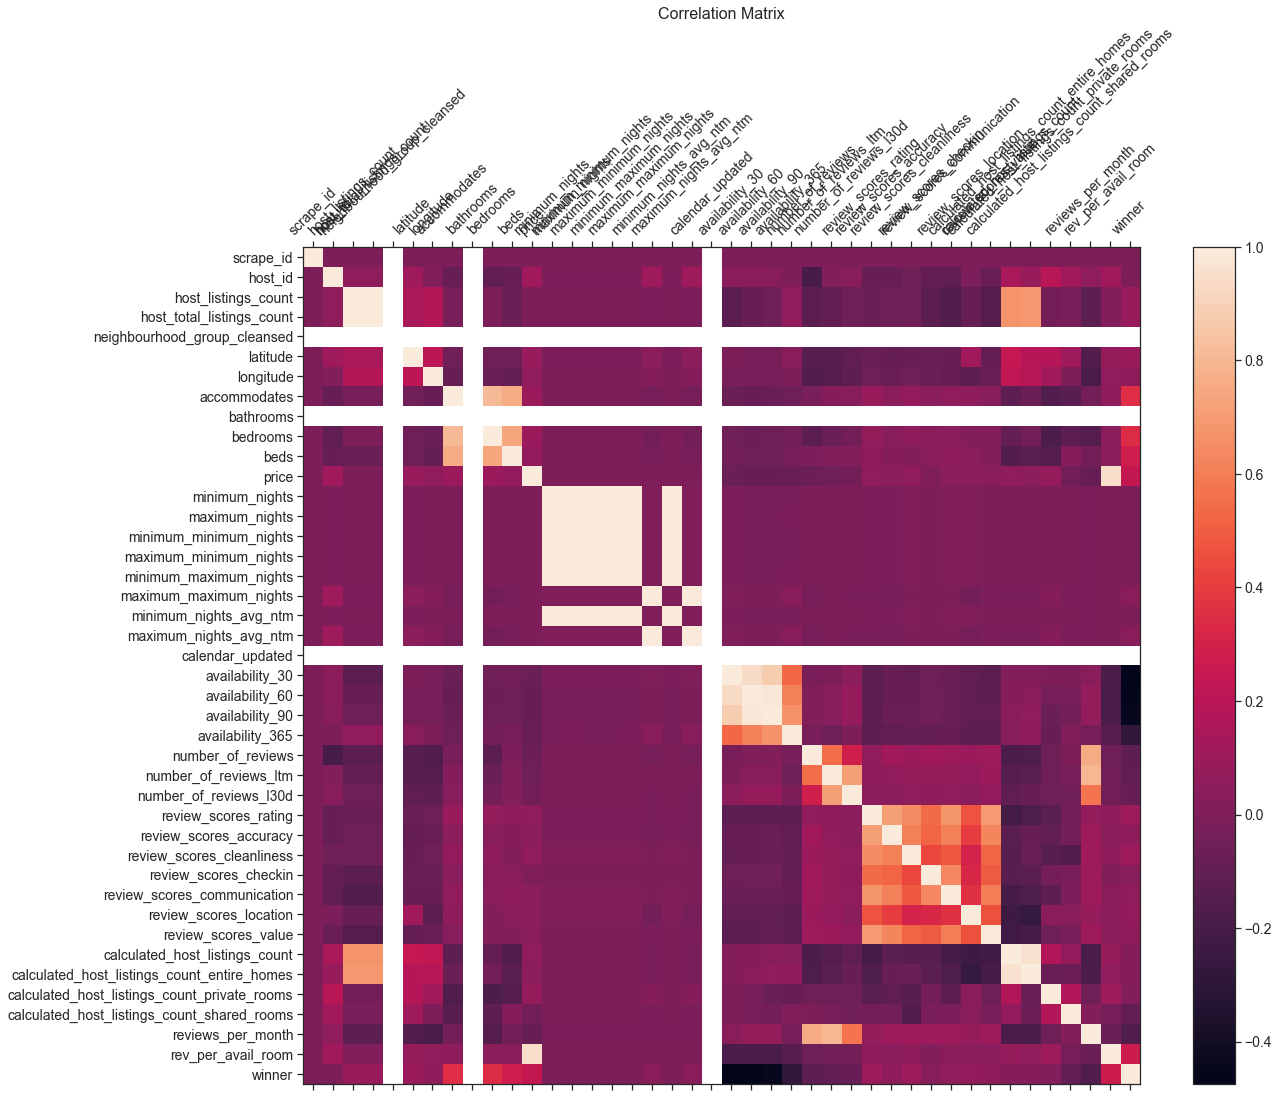

In [63]:
#correlation with numerical values 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_vars = listings.select_dtypes(include=numerics)

#Correlation plot 
f = plt.figure(figsize=(19, 15))
plt.matshow(numeric_vars.corr(), fignum=f.number)
plt.xticks(range(numeric_vars.shape[1]), numeric_vars.columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_vars.shape[1]), numeric_vars.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In this plot the higher correlations with the variable price are:accomodates, bedrooms, beds and reviews scores rating. 

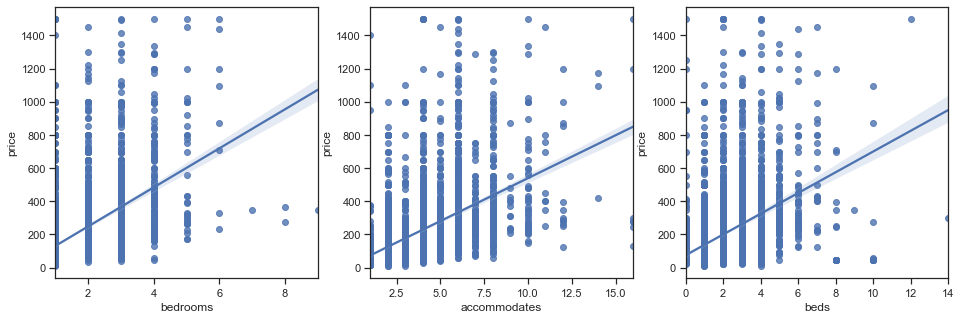

In [64]:
#Correlation Plot with regression 
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
numeric_vars_ =numeric_vars[numeric_vars['price'] <= 1500]
sns.regplot(x='bedrooms', y='price', data=numeric_vars_, ax=axs[0])
sns.regplot(x='accommodates', y='price', data=numeric_vars_, ax=axs[1])
sns.regplot(x='beds',y='price', data=numeric_vars_, ax=axs[2])
plt.show()

This plot show us the linear correlation with the price variable.

[Text(0, 0, 'alarm",'),
 Text(1, 0, '"wifi",'),
 Text(2, 0, 'and'),
 Text(3, 0, '"smoke'),
 Text(4, 0, '"essentials",'),
 Text(5, 0, '"heating",'),
 Text(6, 0, '"hangers",'),
 Text(7, 0, 'monoxide'),
 Text(8, 0, '"carbon'),
 Text(9, 0, '"hair'),
 Text(10, 0, '"iron",'),
 Text(11, 0, '"tv",'),
 Text(12, 0, '["kitchen",'),
 Text(13, 0, 'dryer",'),
 Text(14, 0, '"dedicated'),
 Text(15, 0, 'workspace"]'),
 Text(16, 0, '"hot'),
 Text(17, 0, '"dryer",'),
 Text(18, 0, '"washer",'),
 Text(19, 0, 'extinguisher",'),
 Text(20, 0, '"fire'),
 Text(21, 0, '"shampoo",'),
 Text(22, 0, 'allowed",'),
 Text(23, 0, '"free'),
 Text(24, 0, 'water",'),
 Text(25, 0, 'maker",'),
 Text(26, 0, '"refrigerator",'),
 Text(27, 0, '"coffee'),
 Text(28, 0, '"dishes'),
 Text(29, 0, 'silverware",'),
 Text(30, 0, '"microwave",'),
 Text(31, 0, 'on'),
 Text(32, 0, 'or'),
 Text(33, 0, '"first'),
 Text(34, 0, 'aid'),
 Text(35, 0, 'kit",'),
 Text(36, 0, '"private'),
 Text(37, 0, 'linens",'),
 Text(38, 0, '"bed'),
 Text(39, 0,

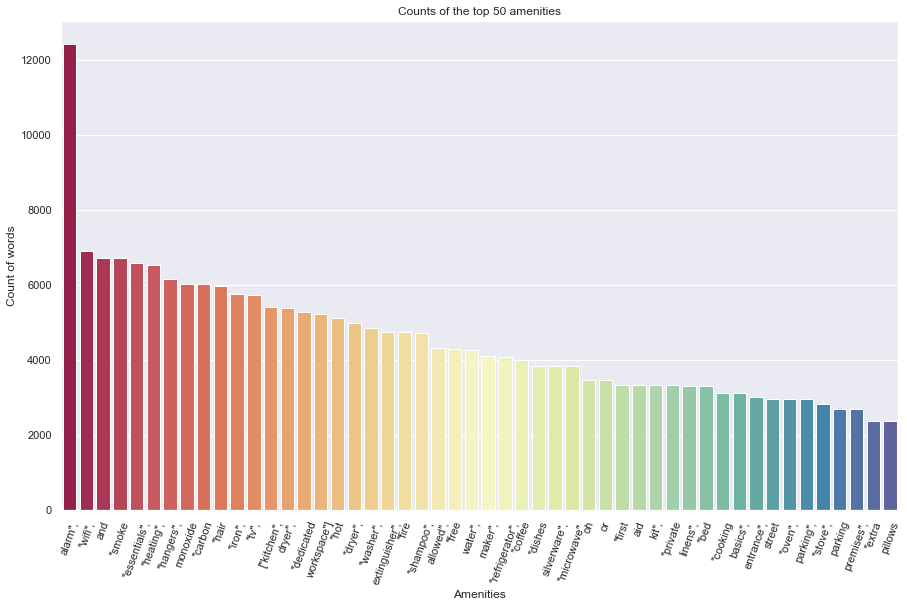

In [65]:
#Plot counting ameneities 
amen_listings=[]
for amen in listings.amenities:
    amen_listings.append(amen) 
    
def splitting(amen):
    splt=str(amen).split()
    return splt 

amen_count=[]

for i in amen_listings:
    for j in splitting(i):
        words = j.lower()
        amen_count.append(words)
        
#See the 50 most frequent amenities
top_50_words=Counter(amen_count).most_common()
top_50_words=top_50_words[0:50]

amen_table=pd.DataFrame(top_50_words)
amen_table.rename(columns={0:'amenities', 1:'count'}, inplace=True)

#plot 
sns.set(rc={'figure.figsize':(15,9)})
graph_8=sns.barplot(x='amenities', y='count', data= amen_table, palette = "Spectral")
graph_8.set_title('Counts of the top 50 amenities')
graph_8.set_ylabel('Count of words')
graph_8.set_xlabel('Amenities')
graph_8.set_xticklabels(graph_8.get_xticklabels(), rotation=70)

The amenities that host tend to post are: smokre alarm, carbon monoxide alarm, essentials, heating, hangers, tv, kitchen, dryer, washer, extinguisher.

In [66]:
#Create a new base
features_2 = listings.iloc[: ,[15, 25,29,30,31,34,37,58,71]].join(listings.iloc[:,73:339])
#we apply dummy fucntion to this object variables
#filter 
top_amenities = features_2[['Smoke alarm', 'Carbon monoxide alarm', 'Essentials', 'Heating', 'Cable TV', 'Kitchen',
                            'Wifi', 'Hangers','Hair dryer','Washer', 'Fire extinguisher',
                            'host_is_superhost', 'neighbourhood_cleansed','property_type', 'room_type','price',
                            'winner' ]]

#top_amenities= pd.get_dummies(top_amenities, columns=['host_is_superhost', 'neighbourhood_cleansed','property_type', 'room_type'])

In [67]:
#Applying ordinal econder 
enc = OrdinalEncoder()
enc.fit(top_amenities.iloc[:,0:11])
top_amenities.iloc[:,0:11]= enc.transform(top_amenities.iloc[:,0:11])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [68]:
#group by winners and no winners 
top_amenities_winners = top_amenities[top_amenities['winner'] == 1]
top_amenities_nowinners = top_amenities[top_amenities['winner'] == 0]

In [69]:
#limit the variability of price variable 
top_amenities_1000 = top_amenities[top_amenities['price'] <=1000]

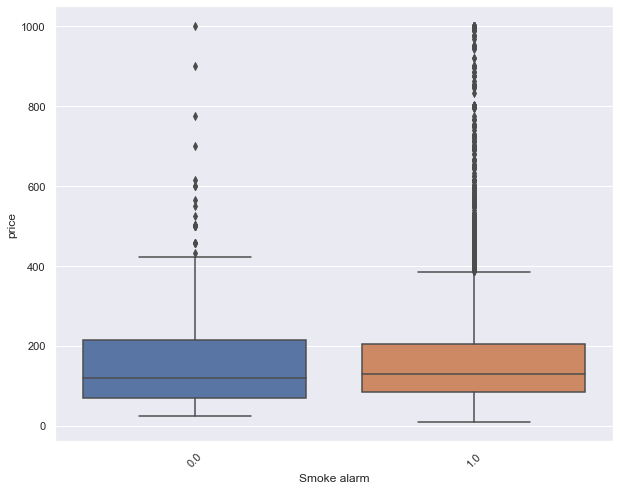

In [70]:
#box plot of Smoke alarm 
plt.figure(figsize=(10,8))
sns.boxplot(x='Smoke alarm',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

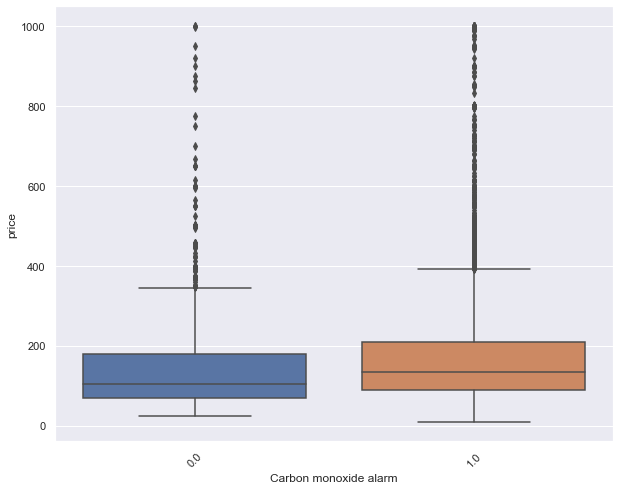

In [71]:
#box plot of Carbon monoxide alarm 
plt.figure(figsize=(10,8))
sns.boxplot(x='Carbon monoxide alarm',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

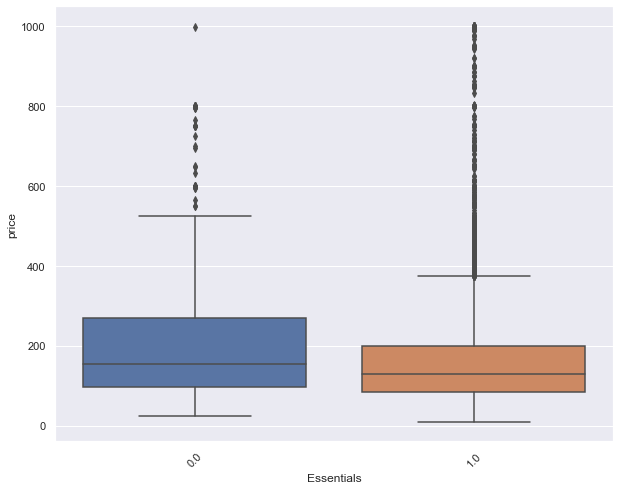

In [72]:
#box plot of Essentials
plt.figure(figsize=(10,8))
sns.boxplot(x='Essentials',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

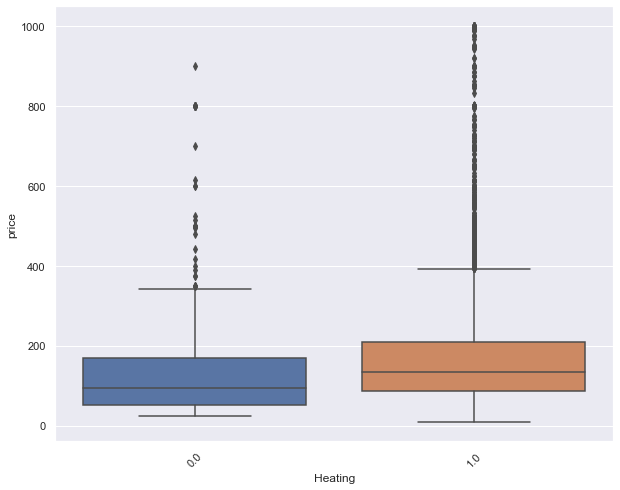

In [73]:
#box plot of Heating
plt.figure(figsize=(10,8))
sns.boxplot(x='Heating',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

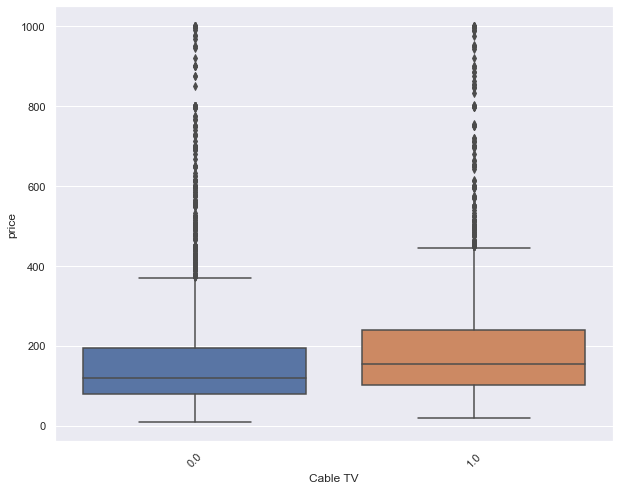

In [74]:
#box plot of Cable TV
plt.figure(figsize=(10,8))
sns.boxplot(x='Cable TV',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

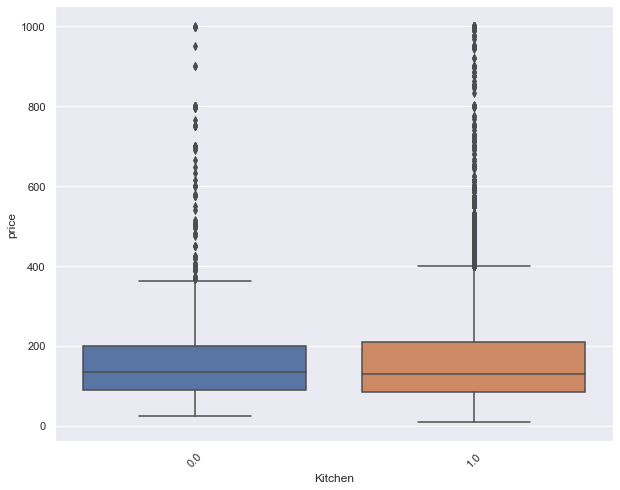

In [75]:
#box plot of Kitchen
plt.figure(figsize=(10,8))
sns.boxplot(x='Kitchen',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

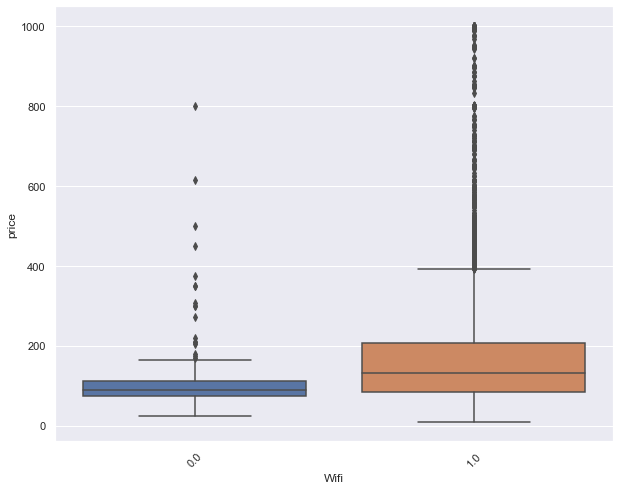

In [76]:
#box plot of Wifi
plt.figure(figsize=(10,8))
sns.boxplot(x='Wifi',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

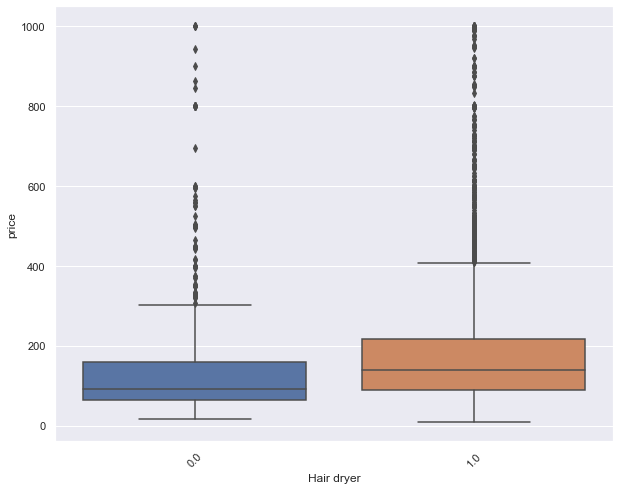

In [77]:
#box plot of Hair Dryer
plt.figure(figsize=(10,8))
sns.boxplot(x='Hair dryer',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

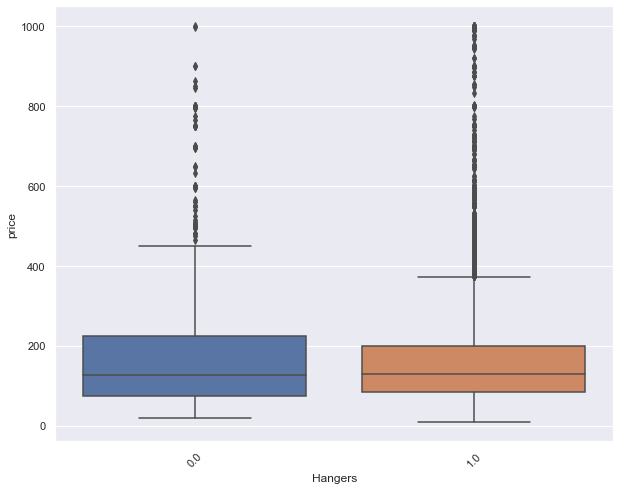

In [78]:
#box plot of Hangers
plt.figure(figsize=(10,8))
sns.boxplot(x='Hangers',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

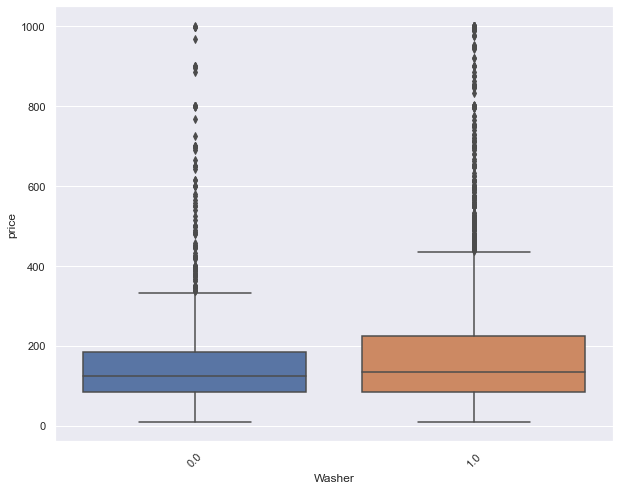

In [79]:
#box plot of Washer
plt.figure(figsize=(10,8))
sns.boxplot(x='Washer',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

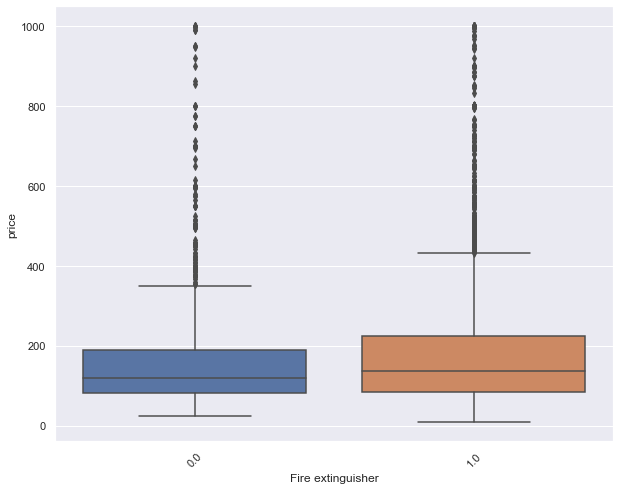

In [80]:
#box plot of Fire extinguisher
plt.figure(figsize=(10,8))
sns.boxplot(x='Fire extinguisher',y='price',data= top_amenities_1000)
plt.xticks(rotation=45)
plt.show()

Expensive rentals tend to have carbon monoxide, hayr dries, tv cable, wi-fi, washer and heating.

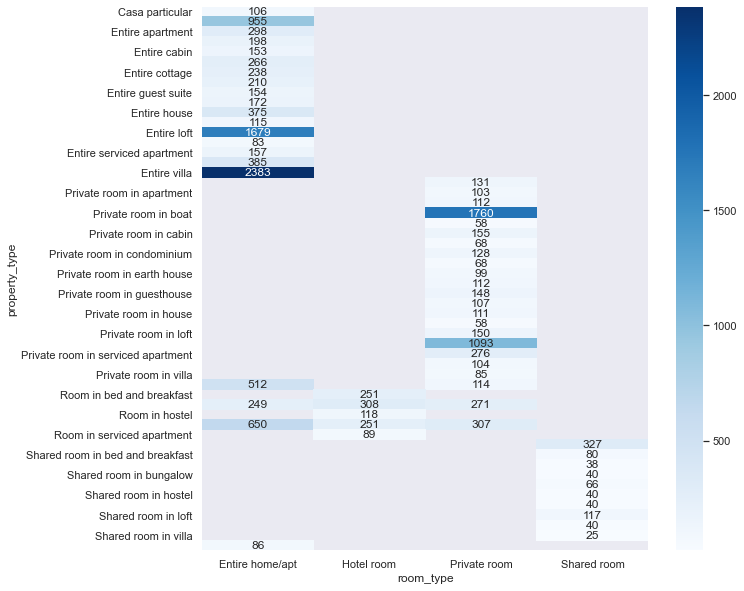

In [81]:
# heatmap of price vs property and room type
fig, ax = plt.subplots(figsize=(10,10));
bos_heat = sns.heatmap(listings.groupby(['property_type','room_type']).price.mean().unstack(),cmap="Blues",annot=True, fmt=".0f",ax=ax);
fig = bos_heat.get_figure()

Almost all the shared rooms tend to be the most cheap rooms. And the Entire home/apartment types expensive. 

In [83]:
#Table of top 10 best neighbourhoods in terms of number of listings
sf_neigh_pr_df = listings.groupby(['neighbourhood_cleansed']).agg({'host_id': 'count', 'latitude': 'mean', 'longitude': 'mean', 'price': 'mean'})
sf_neigh_pr_df.rename(index=str, columns={"host_id": "total_num_list"},inplace=True)
sf_neigh_pr_df.sort_values(by=['total_num_list'], ascending=False).head(10)

,total_num_list,latitude,longitude,price
neighbourhood_cleansed,,,,
Downtown/Civic Center,697,37.786037,-122.412566,283.678623
Mission,649,37.758864,-122.417295,170.093991
South of Market,532,37.778785,-122.403366,219.813910
Western Addition,486,37.777697,-122.433029,194.125514
Haight Ashbury,345,37.769632,-122.446015,203.666667
Castro/Upper Market,339,37.762689,-122.434966,256.678466
Bernal Heights,314,37.741446,-122.416264,172.140127
Noe Valley,296,37.750210,-122.433055,208.337838
Nob Hill,291,37.792706,-122.415703,208.384880


The top 10 neighbouhoods in terms of number of listings are : Downtown/Civic center, Mission, South of Market, 
Western Addition, Haight Ashbury, Castro/Upper Market, Bernal Heights, Noe Valley,  Nob Hill, Outer Sunset. 

## Quation 3

We model the price of the rentals. At least, we know that prices depend on 
many variables. Those factors, in a certain way, contributes to the pattern of prices. 
The variation of prices is called noise. We need to ignore this noise in order to model 
the prices. 

The R squared (Coefficient of determination) represents the coefficient of how well the values 
fit compared to the original values. The value from 0 to 1 interpreted as percentages. 
The higher the value is, the better the model is.
The R squared in the Train is grater than the R squared in Test, this means that 
the model doesn't generalize very well.

The Rmse (Root Mean Squared Error) is the error rate by the square root of MSE. And MSE
represents the difference between the original and predicted values extracted by 
squared the average difference over the data set.
Test RMSE is greater than Train RMSE, which means that there is some overfitting 
in the model.

### Vizualization

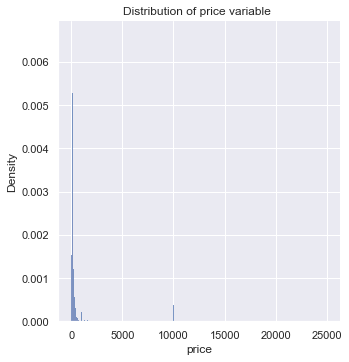

In [84]:
#Plot of price with density 
sns.displot(factors.price, stat = 'density')
plt.title("Distribution of price variable ")
plt.show()

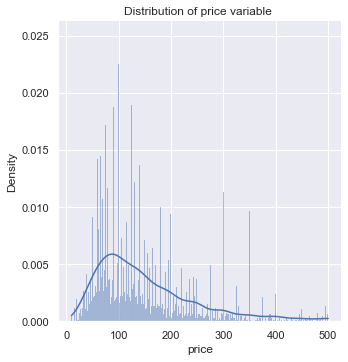

In [85]:
#Plot of price without outliers 
factors_price = factors[factors['price'] <= 500]
sns.displot(factors_price.price, stat= 'density', discrete = True, kde = True)
plt.title("Distribution of price variable ")
plt.show()

In this plot we see the density probabily of price variable. Almos all prices concentrate to the left side, between 
0 and 300 dollars. 

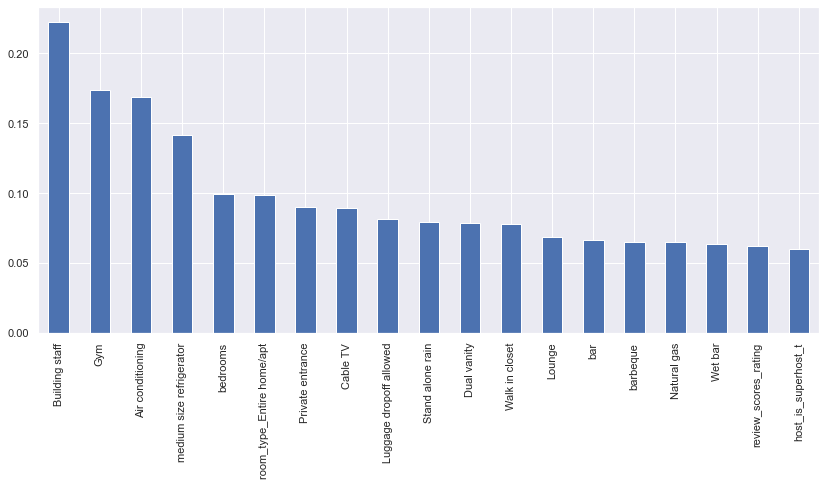

In [95]:
#Bar Plot correlations 
corr_with_sale_price = factors.corr()["price"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.head(20).drop("price").plot.bar()
plt.show()

This plot bar show us the higher correlations with the variable price, The top 10 variables with high correlation are : Building staff, gym, air conditioning, bedrooms, entire apartment type room, private entrance, cable tv, luggage drop off allowed and stand alone rain.

In [87]:
#feature importance for predcition model prices
from collections import OrderedDict
OrderedDict(sorted(xgb2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('reviews_per_month', 26902),
             ('availability_365', 20060),
             ('number_of_reviews', 13574),
             ('review_scores_rating', 11475),
             ('maximum_nights', 9752),
             ('availability_90', 8806),
             ('bedrooms', 8513),
             ('minimum_maximum_nights', 7109),
             ('availability_30', 6863),
             ('availability_60', 5576),
             ('First aid kit', 2997),
             ('maximum_minimum_nights', 2800),
             ('minimum_minimum_nights', 2774),
             ('Private entrance', 2738),
             ('Fire extinguisher', 2613),
             ('Cable TV', 2586),
             ('minimum_nights_avg_ntm', 2532),
             ('Washer', 2497),
             ('Dedicated workspace', 2219),
             ('Long term stays', 2187),
             ('Hot water', 2079),
             ('host_is_superhost_f', 2059),
             ('Shampoo', 1952),
             ('Lockbox', 1937),
             ('Bed linens', 1875),


The top 10 most important vairbales, for explianing the model prices are :
reviews_per_month, availability_365, number_of_reviews, review_scores_rating,
maximum_nights, availability_90, bedrooms, maximum_maximum_nights, availability_30,
availability_60